In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
from lmfit.models import GaussianModel
import sklearn.utils as sk

In [2]:
#flare module in same directory
import flare as f
from importlib import reload as reload
import warnings
warnings.filterwarnings("ignore")

In [3]:
#define functions for quick saving of figures
def ps(name):
    '''save as postscript file'''
    plt.savefig(name+'.ps')
def png(name,dpi=200):
    '''save as png with sufficient quality'''
    plt.savefig(name+'.png',dpi=dpi,bbox_inches='tight')

In [4]:
#load Ogle IV, only keep first three columns
og4 = np.loadtxt('phot.dat',usecols=range(0,3))
#turn into panda dataframe with labelled columns based on known time units (Julian Date)
og4 = pd.DataFrame(og4,columns=['JD','I mag','I mag err'])
#add columns for MJD and MJD-50000, which will be the time unit used in all plots
og4['MJD'] = og4['JD']-2400000.5
og4['MJD-50000'] = og4['MJD']-50000
og4['I mag'] = og4['I mag']+.041 #calibrating
#deleting duplicates (points with same time)
og4 = og4.drop_duplicates(subset=['MJD'], keep='last')
#making sure it is sorted by time
sog4 = og4.sort_values(by='MJD')

In [5]:
#since duplicates dropped, need to redo indexing
sog4['ind'] = np.arange(len(sog4))
sog4 = sog4.set_index('ind')

In [6]:
#add column of detrended data
Imag=sog4['I mag']
window=201 #also tested other windows to make sure periodogram results unaffected
print('Smooth (window = ', window, ') and detrend data...')
Ismooth = signal.savgol_filter(Imag, window, 1)
Imean = np.mean(Imag)
print('Average I band magnitude', Imean)
sog4['I detrend 2'] = Imag-Ismooth  + sog4['I mag'].mean()

print('min:',sog4['I detrend 2'].min(),'max:',sog4['I detrend 2'].max())

Smooth (window =  201 ) and detrend data...
Average I band magnitude 14.69307702182286
min: 14.590290952171113 max: 14.785156623812906


In [7]:
#use flare index bounds from OGLE_LXP69.5_Final
#editing b/c of extra end points in some
flareinds = [[40, 130],[160, 235],[241, 258],[330, 420],[478, 507],[510, 536],[540, 576],
 [585, 600],[600, 630],[630, 660],[671, 700],[711, 738],[738, 758]]

# Variables Names

- __out: direct result(s) from model fit
- __fr: DataFrame made using __out
    - gout: regular gaussian fit (I max mag - I mag)
    - gfr: corresponding DataFrame; one row per flare
    - goff_outs: list of outputs from gaussian model with different vertical offsets
    - goff_frs: corresponding DataFrames
- __centers: arrays of center values for 13 flares
    - gcenters: regular gaussian
    - det_centers: gaussian w/ no offset on detrended data
    - glcenters: gaussian+line on original data
    - det_glcenters: gaussian+ line on detrended data

# Running Summary of Findings and Choices 
- using 0 offset for other models; can easily shift these later, but offsets don't affect the centers very much
- offsets and choice of original vs. detrended doesn't matter much
- choice of model is more important (e.g. gaussian vs. gaussian+line)

# 1. Start With Simple Gaussian Model
- fits maximum I mag from given flare minus original I mag data

In [8]:
reload(f)
gout,gfr = f.gparams(sog4,flareinds,more=True)

In [9]:
gfr

,center,sigma,fwhm,height,amp
0,5497.025629,41.5431,97.8266,0.0934717,9.7335
1,5653.721665,28.3393,66.7339,0.0421773,2.9961
2,5798.592549,13.5255,31.8501,0.0428358,1.45228
3,5960.250938,25.8462,60.8631,0.0824376,5.34087
4,6318.469159,49.0652,115.54,0.13053,16.0536
5,6637.294439,43.373,102.136,0.0982059,10.677
6,6988.882603,52.8623,124.481,0.117869,15.6183
7,7313.795244,28.4759,67.0556,0.0560571,4.00127
8,7476.981892,42.911,101.048,0.0925337,9.95311
9,7682.035391,43.7959,103.131,0.0956596,10.5015


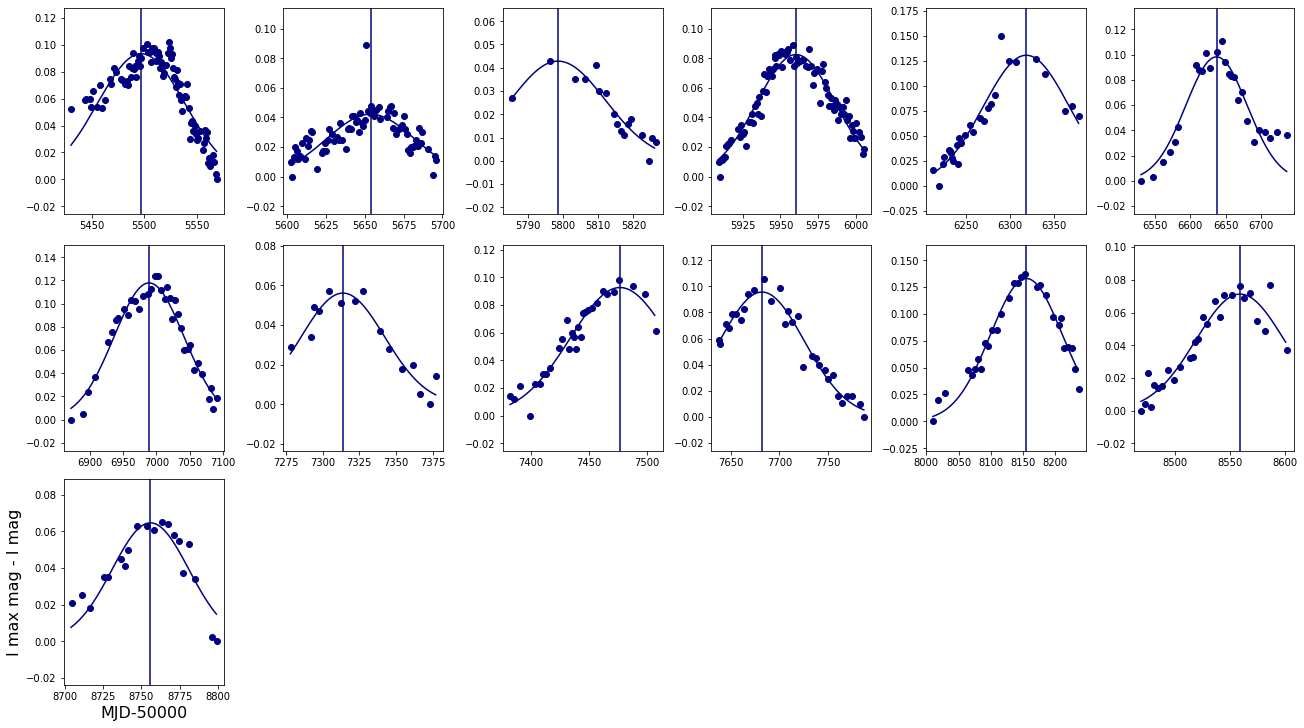

In [10]:
#plot fits
#reload(f)
f.plflares(gout,[gfr['center']],flareinds,sog4,ylabel='I max mag - I mag')

In [11]:
#save centers separately for easier access
gcenters = np.array(gfr['center'])
gcenters

array([5497.02562862, 5653.72166481, 5798.59254892, 5960.25093808,
       6318.46915905, 6637.29443862, 6988.8826026 , 7313.79524415,
       7476.98189219, 7682.03539062, 8155.10721353, 8559.43375779,
       8755.94374512])

In [12]:
f.oneflareg(sog4,[50],[130])

st: 50 end: 130 cen: 5503.144988272812


array([[5503.14498827]])

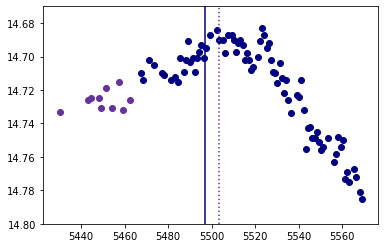

In [13]:
#looks too low for first flare
plt.scatter(sog4['MJD-50000'][50:130],sog4['I mag'][50:130],color='navy')
plt.scatter(sog4['MJD-50000'][40:50],sog4['I mag'][40:50],color='rebeccapurple')

plt.ylim(14.8,14.67)
plt.axvline(5497.02562862,color='navy')
plt.axvline(5503.14,color='rebeccapurple',linestyle='dotted')
png('firstflarestart')

# 2. Gaussians with Different Offsets
- fits maximum I mag from given flare minus original I mag data + some offset
- addresses the fact that brightness minimum (max I mag) may not be actual minimum of the given flare

In [14]:
goff_outs = []
goff_frs = []
#try out offsets 0-.08; repeat of 0 vertical offset
for g in [0,.02,.04,.06,.08]:
    touts,tfits = (f.gparams(sog4,flareinds,offset=g,more=True))
    goff_outs.append(touts)
    goff_frs.append(tfits) #report by flare

In [15]:
#DataFrame for .08 vertical offset
goff_frs[4]

,center,sigma,fwhm,height,amp
0,5495.703475,64.9241,152.885,0.17182,27.9621
1,5652.119264,60.8705,143.339,0.119967,18.3045
2,5797.531079,33.3445,78.5203,0.117985,9.86143
3,5960.136426,44.1723,104.018,0.158568,17.5571
4,6318.537359,77.5551,182.628,0.20021,38.9211
5,6640.305514,80.2321,188.932,0.169468,34.082
6,6988.060270,82.0217,193.146,0.193105,39.7019
7,7313.846803,62.2713,146.638,0.131019,20.4509
8,7483.520625,82.1048,193.342,0.167193,34.4093
9,7681.298782,80.2038,188.866,0.167323,33.6387


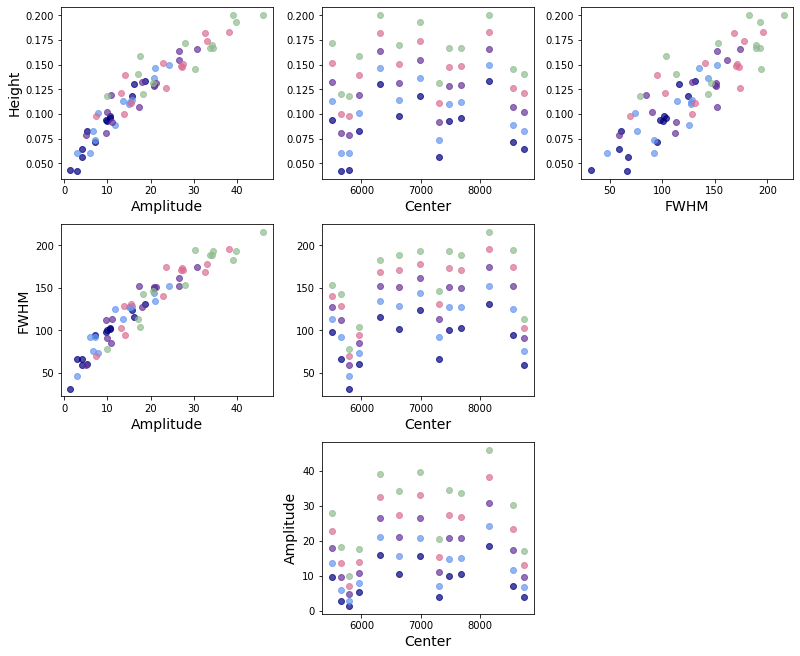

In [16]:
#compare parameter relationships 
f.plotrel(goff_frs)
#order of colors for increasing offsets: 'navy','cornflowerblue','rebeccapurple','palevioletred','darkseagreen'
#will plot these centers onto flares lower down

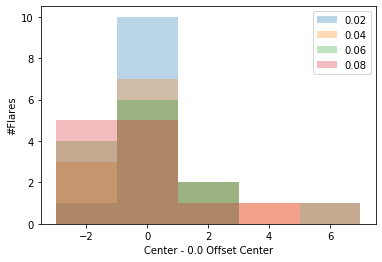

In [17]:
labels = ['0.02','0.04','0.06','0.08']
for i in range(4):
    a = plt.hist(goff_frs[i+1]['center']-gcenters,bins=[-3,-1,1,3,5,7],alpha=.3,label=labels[i])
plt.legend()
plt.xlabel('Center - 0.0 Offset Center')
plt.ylabel('#Flares')
png('offsethist')

# 3. Gaussian Fitting on Detrended Data

In [18]:
#offset 0; detrended 
det_outs, det_gfits = f.gparams(sog4,flareinds,mags=5,more=True)
#save array of centers from gaussian on detrended 
det_centers = np.array(det_gfits['center'])

In [19]:
#difference between detrended and original data centers
det_centers - gcenters

array([ 2.98749138,  0.01916715, -0.50179445, -2.41215027,  0.64507827,
       -1.77028734, -0.91464701, -1.424174  ,  1.15619402,  0.61187209,
        1.34231682,  1.35744809,  1.30548007])

In [20]:
det_centers[0]

5500.01311999625

# 4. Gaussian + Line
- gaussian + line on original data
- gaussian + line on detrended data
- compare centers obtained thus far

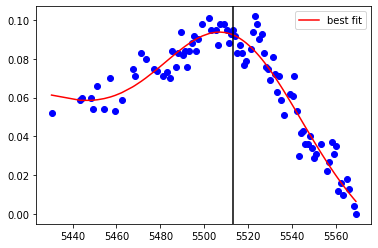

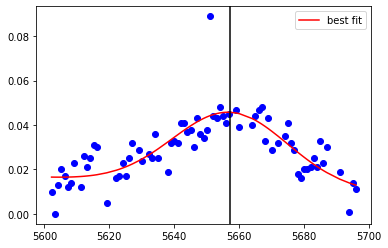

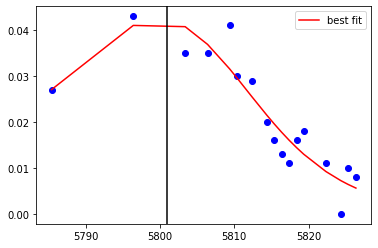

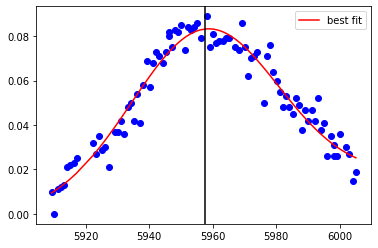

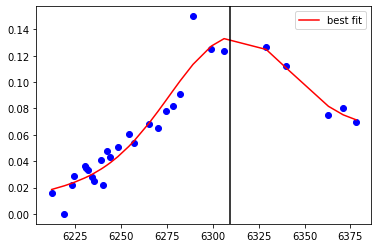

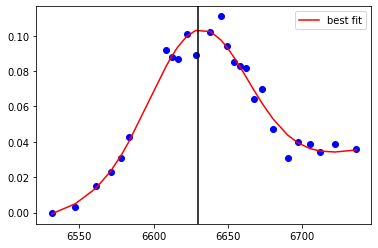

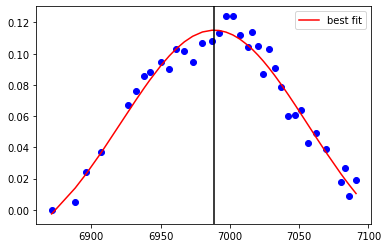

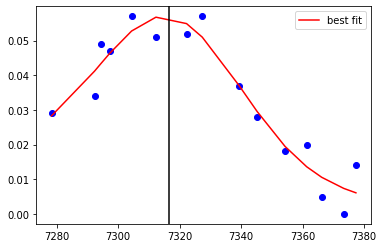

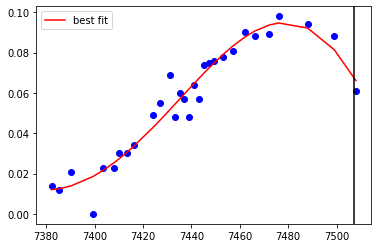

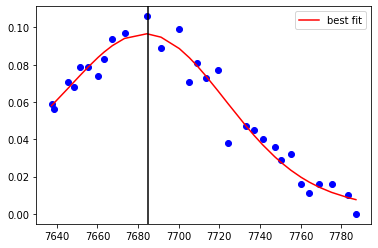

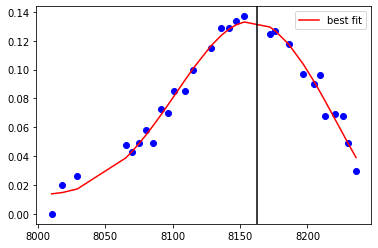

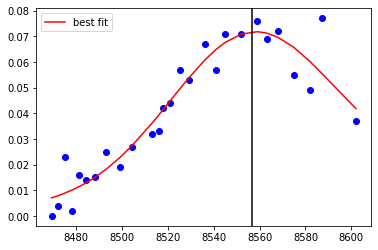

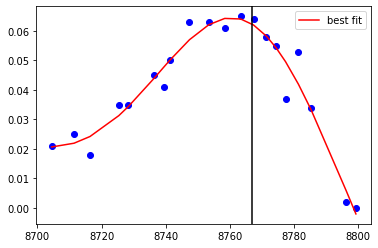

In [21]:
#gaussian+line function currently fits one flare; center result constrained to being within 30 days of guess; offset 0
reload(f)
glcenters = []
glout = []
#doesn't produce analogous data frame
for i in range(13):
    #prints each center result
    flfit = f.gaussline(sog4,flareinds,i,gout) #can set to True to print out each flare fit
    glout.append(flfit)
    glcenters.append(flfit['cen'])
#plots in output: worked on all but index 8 flare; looks too far to the right

In [22]:
#don't include the value of 30; not a reasonable fit
glcenters - gcenters

array([16.3177995 ,  3.47109613,  2.36734083, -2.59724753, -8.90984757,
       -7.07277218, -0.05590317,  2.66273938, 29.9999869 ,  2.96920678,
        7.45920489, -2.94067683, 10.94105371])

In [23]:
glcenters[8] = np.nan

In [24]:
np.nanstd(glcenters - gcenters)

6.889018182727357

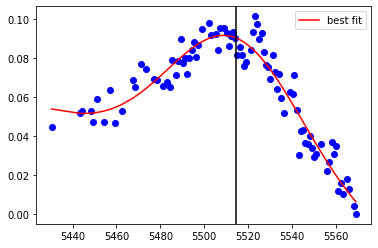

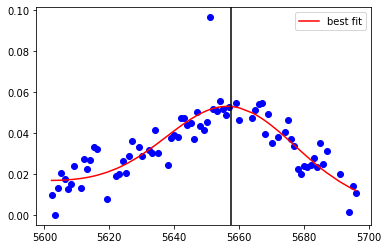

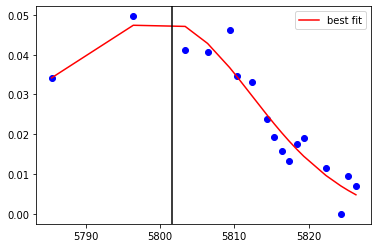

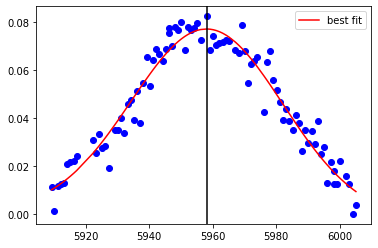

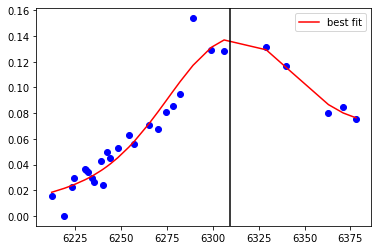

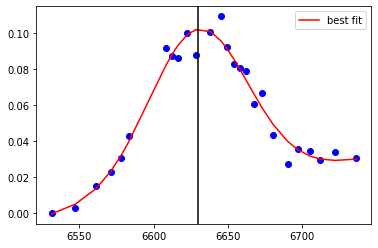

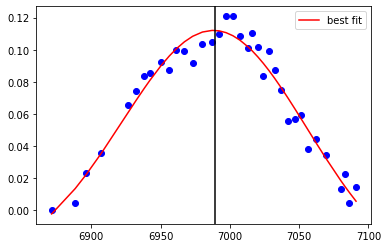

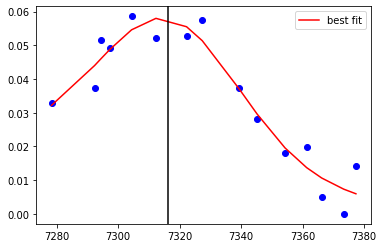

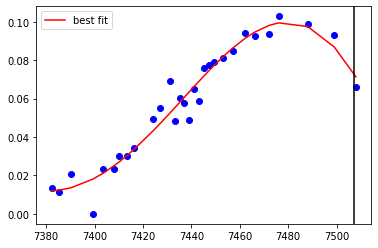

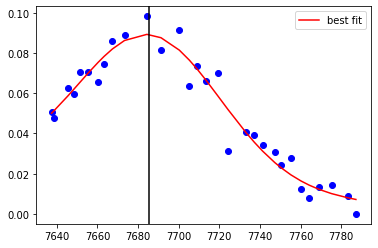

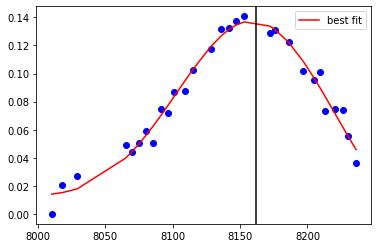

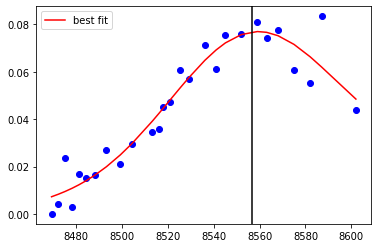

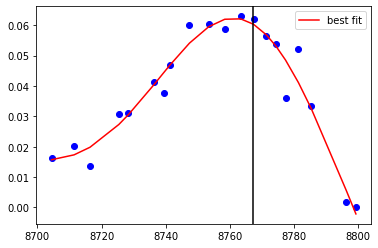

In [25]:
#repeat on detrended data
det_glcenters = []
det_glout = []
#doesn't produce analogous data frame
for i in range(13):
    flfit = f.gaussline(sog4,flareinds,i,gout,mags=5) #can set to True to print out each flare fit
    det_glout.append(flfit)
    det_glcenters.append(flfit['cen'])

In [26]:
#for now, setting 8 to nan
det_glcenters[8] = np.nan

In [27]:
det_glcenters - np.array(glcenters)

array([ 1.01499762,  0.19932293,  0.69508063,  0.61275809, -0.10521076,
       -0.22730534,  0.20751353, -0.254244  ,         nan,  0.51494604,
       -0.44814911,  0.24118341,  0.2564419 ])

### Comparing Models Used Thus Far
- different vertical offsets: 0 to .08 in steps of .02
- gaussian on detrended data
- gaussian+line on original and detrended data


In [28]:
off2_centers = np.array(goff_frs[1]['center'])
off4_centers = np.array(goff_frs[2]['center'])
off6_centers = np.array(goff_frs[3]['center'])
off8_centers = np.array(goff_frs[4]['center'])


In [29]:
#all gaussian centers; same order as labels below
all_gcens = [gcenters,off2_centers,off4_centers,off6_centers,off8_centers,
            det_centers,glcenters,det_glcenters]

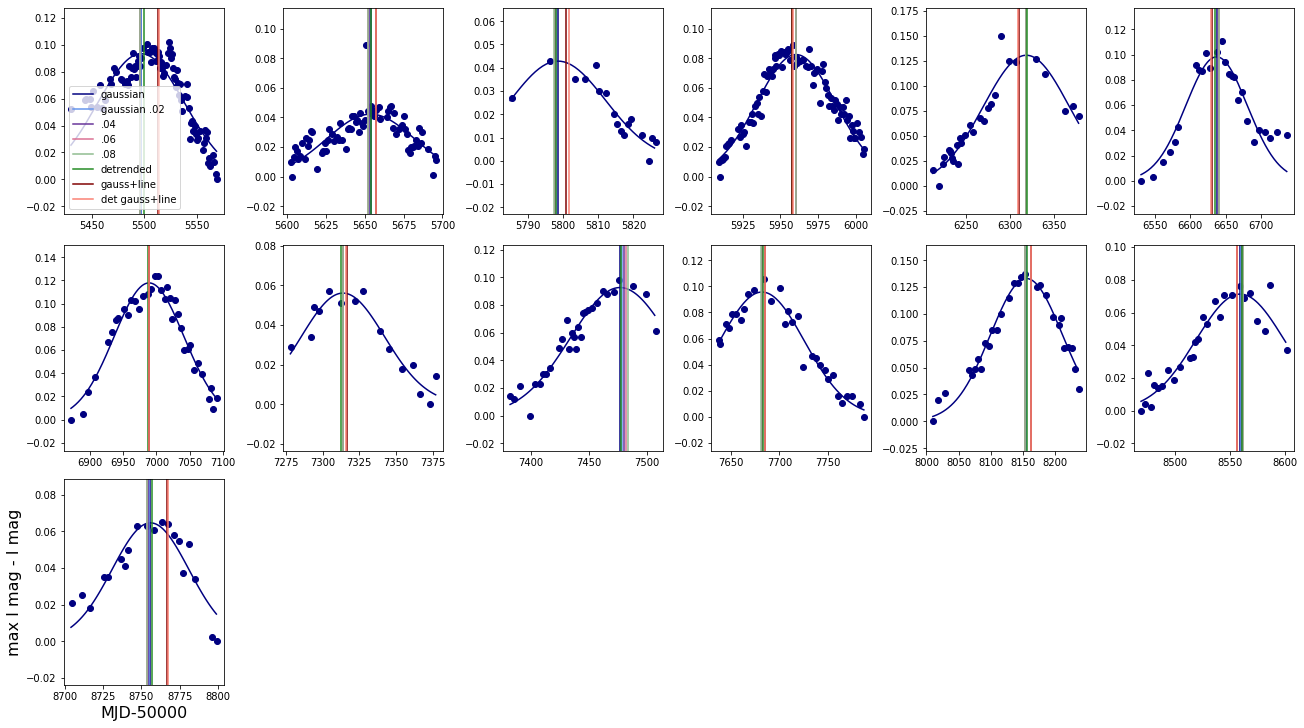

In [30]:
reload(f)
f.plflares(gout,all_gcens,flareinds,sog4,label=True,
           labels=['gaussian','gaussian .02','.04','.06','.08','detrended','gauss+line','det gauss+line'],
          ylabel='max I mag - I mag')
png('allgauss')

In [31]:
hist_gcens = [det_centers,off6_centers,glcenters,det_glcenters]

5.104865799062515

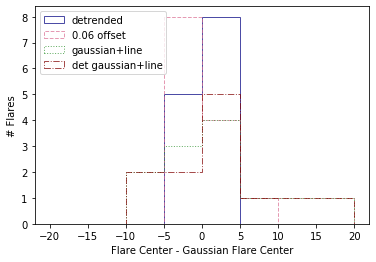

In [32]:
#histogram comparing centers to the simplest 0 offset gaussian model on the original data
#colors are by model, and do not show individual flares; colors different from above sine only showing one extra offset
reload(f)
#works with default labels here
f.flarehist(hist_gcens,gcenters)
#prints standard deviation
#png('gflarehist')

# 5. Testing Changes in Index Ranges for Flares
- most noticeable with first flare, but check others as well
- just gaussian model differences here; investigating one flare at a time
- add onto these analyses with triangle fits

#### flare 1

In [33]:
flareinds[0]

[40, 130]

(14.8, 14.67)

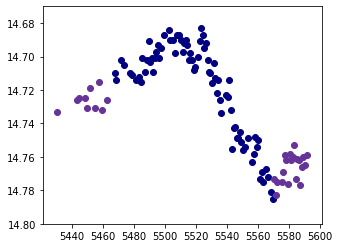

In [34]:
#inds used thus far: 40 to 130; so all but the purple on the right
plt.figure(figsize=(5,4))
plt.scatter(sog4['MJD-50000'][50:130],sog4['I mag'][50:130],color='navy')
plt.scatter(sog4['MJD-50000'][40:50],sog4['I mag'][40:50],color='rebeccapurple')
plt.scatter(sog4['MJD-50000'][130:150],sog4['I mag'][130:150],color='rebeccapurple')
plt.ylim(14.8,14.67)

In [35]:
#gaussian fits on first flare using different indices
reload(f)
centest = f.oneflareg(sog4,[40,45,50],[130,140,150])
#~6 day variation

st: 40 end: 130 cen: 5497.025628616601
st: 40 end: 140 cen: 5496.984408265616
st: 40 end: 150 cen: 5496.8193154053915
st: 45 end: 130 cen: 5500.299165649939
st: 45 end: 140 cen: 5500.228478221
st: 45 end: 150 cen: 5499.927741865595
st: 50 end: 130 cen: 5503.144988272812
st: 50 end: 140 cen: 5502.978167292372
st: 50 end: 150 cen: 5502.406933702004


([<matplotlib.axis.YTick at 0x1a2009ea50>,
 <a list of 3 Text yticklabel objects>)

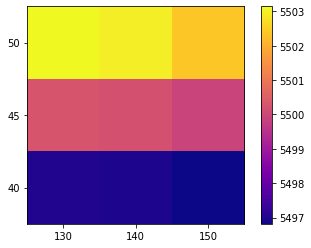

In [36]:
im = plt.imshow(centest,origin='lower',cmap='plasma')
plt.colorbar()
plt.xticks([0,1,2],[130,140,150]) #y-axis is end (j in loop)
plt.yticks([0,1,2],[40,45,50])

In [37]:
#six day variation
centest = f.oneflareg(sog4,[40,45,50],[130,140,150],det=True)

st: 40 end: 130 cen: 5500.01311999625
st: 40 end: 140 cen: 5499.972133342631
st: 40 end: 150 cen: 5499.866747488944
st: 45 end: 130 cen: 5502.682394166494
st: 45 end: 140 cen: 5502.624076359064
st: 45 end: 150 cen: 5502.407726394688
st: 50 end: 130 cen: 5505.068944695662
st: 50 end: 140 cen: 5504.934930528838
st: 50 end: 150 cen: 5504.4925596884505


In [38]:
reload(f)
centest = f.oneflareg(sog4,[40,45,50],[130,140,150],gline=True)

In [39]:
centest

array([[5513.34342886, 5511.00608603, 5510.05080624],
       [5514.23028687, 5512.39713159, 5511.27473618],
       [5516.58173018, 5515.03811522, 5513.36408993]])

In [40]:
#last test for flare one: detrended and gauss+line
centest = f.oneflareg(sog4,[40,45,50],[130,140,150],gline=True,det=True)
centest

array([[5513.34342886, 5511.00608603, 5510.05080624],
       [5514.23028687, 5512.39713159, 5511.27473618],
       [5516.58173018, 5515.03811522, 5513.36408993]])

> so within each model, we see a variation using different start and end indices of ~6 days
> - however, there's no real justification for the extra data at the end or deleting some at the beginning
> - last step for this flare: try by just changing the end cutoff, since that's actually unclear
> - see result below: not that much of an issue of we choose any range of reasonable points (all/almost all points within a flare, exclusing points that are part of the next one)
> - the strange thing was just that cutting some data from the start makes the fit look better, but that's probably more of an argument for not using the simple gaussian model, at least for this first flare

In [41]:
centest = f.oneflareg(sog4,[40],np.arange(128,132),gline=True,det=True)
centest

array([[5512.67325268, 5512.97015383, 5513.34342886, 5513.04341359]])

#### 2

In [42]:
flareinds[1] 

[160, 235]

(14.8, 14.67)

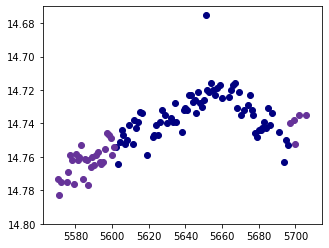

In [43]:
plt.figure(figsize=(5,4))
plt.scatter(sog4['MJD-50000'][160:235],sog4['I mag'][160:235],color='navy')
plt.scatter(sog4['MJD-50000'][130:160],sog4['I mag'][130:160],color='rebeccapurple')
plt.scatter(sog4['MJD-50000'][235:240],sog4['I mag'][235:240],color='rebeccapurple')
plt.ylim(14.8,14.67)

In [44]:
centest = f.oneflareg(sog4,[130,140,150,160],[235,236,237,238,239,240])
#only changes by two days

st: 130 end: 235 cen: 5652.075360734994
st: 130 end: 236 cen: 5652.454137783113
st: 130 end: 237 cen: 5652.955412190214
st: 130 end: 238 cen: 5652.893859168695
st: 130 end: 239 cen: 5653.55079210036
st: 130 end: 240 cen: 5654.316931595589
st: 140 end: 235 cen: 5652.41090137465
st: 140 end: 236 cen: 5652.76689491123
st: 140 end: 237 cen: 5653.229900645652
st: 140 end: 238 cen: 5653.195040513453
st: 140 end: 239 cen: 5653.79196282444
st: 140 end: 240 cen: 5654.479118532225
st: 150 end: 235 cen: 5653.463848388728
st: 150 end: 236 cen: 5653.702261807044
st: 150 end: 237 cen: 5654.005384586438
st: 150 end: 238 cen: 5653.988023644283
st: 150 end: 239 cen: 5654.3687067610745
st: 150 end: 240 cen: 5654.782153408784
st: 160 end: 235 cen: 5653.721664812585
st: 160 end: 236 cen: 5653.9408593867665
st: 160 end: 237 cen: 5654.216216053226
st: 160 end: 238 cen: 5654.209012463961
st: 160 end: 239 cen: 5654.550549546088
st: 160 end: 240 cen: 5654.919405165536


In [45]:
centest = f.oneflareg(sog4,[130,140,150,160],[235,236,237,238,239,240],gline=True)


In [46]:
centest #changes by 11 days

array([[5663.62452   , 5663.21723369, 5655.7386382 , 5655.50781868,
        5652.0244433 , 5650.07069084],
       [5662.22162441, 5656.75922389, 5653.99233658, 5654.08234223,
        5652.68277103, 5652.05203432],
       [5656.95340769, 5655.56573599, 5654.89630037, 5655.04514513,
        5654.64105896, 5654.41821762],
       [5657.19203984, 5656.55099215, 5656.12585678, 5656.27318833,
        5655.93099158, 5655.69449626]])

In [47]:
centest = f.oneflareg(sog4,[130,140,150,160],[235,236,237,238,239,240],det=True)
#two day range

st: 130 end: 235 cen: 5652.121846458738
st: 130 end: 236 cen: 5652.358418942761
st: 130 end: 237 cen: 5652.683743420789
st: 130 end: 238 cen: 5652.591596881567
st: 130 end: 239 cen: 5653.017317505764
st: 130 end: 240 cen: 5653.511116627261
st: 140 end: 235 cen: 5652.471905249094
st: 140 end: 236 cen: 5652.700331051029
st: 140 end: 237 cen: 5653.003000379647
st: 140 end: 238 cen: 5652.94353377552
st: 140 end: 239 cen: 5653.3269382948565
st: 140 end: 240 cen: 5653.7601471108255
st: 150 end: 235 cen: 5653.471885978695
st: 150 end: 236 cen: 5653.625629237245
st: 150 end: 237 cen: 5653.820748371027
st: 150 end: 238 cen: 5653.784293088386
st: 150 end: 239 cen: 5654.018543786843
st: 150 end: 240 cen: 5654.260160501323
st: 160 end: 235 cen: 5653.740831962297
st: 160 end: 236 cen: 5653.877512377012
st: 160 end: 237 cen: 5654.047696605504
st: 160 end: 238 cen: 5654.020391943284
st: 160 end: 239 cen: 5654.220154741752
st: 160 end: 240 cen: 5654.421403667139


In [48]:
centest = f.oneflareg(sog4,[130,140,150,160],[235,236,237,238,239,240],gline=True,det=True)
centest #eleven day range

array([[5663.62452   , 5663.21723369, 5655.7386382 , 5655.50781868,
        5652.0244433 , 5650.07069084],
       [5662.22162441, 5656.75922389, 5653.99233658, 5654.08234223,
        5652.68277103, 5652.05203432],
       [5656.95340769, 5655.56573599, 5654.89630037, 5655.04514513,
        5654.64105896, 5654.41821762],
       [5657.19203984, 5656.55099215, 5656.12585678, 5656.27318833,
        5655.93099158, 5655.69449626]])

#### 4
half flare doesn't really need changing; go to fourth flare


In [49]:
flareinds[3]

[330, 420]

(14.71, 14.6)

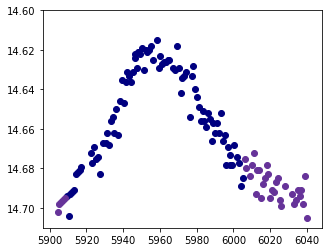

In [50]:
plt.figure(figsize=(5,4))
plt.scatter(sog4['MJD-50000'][330:420],sog4['I mag'][330:420],color='navy')
plt.scatter(sog4['MJD-50000'][325:330],sog4['I mag'][325:330],color='rebeccapurple')
plt.scatter(sog4['MJD-50000'][420:450],sog4['I mag'][420:450],color='rebeccapurple')
plt.ylim(14.71,14.6)

In [51]:
centest = f.oneflareg(sog4,range(325,330),range(420,450,4))
#yay! only varies by a day

st: 325 end: 420 cen: 5960.295704117508
st: 325 end: 424 cen: 5960.513409116956
st: 325 end: 428 cen: 5960.710719179494
st: 325 end: 432 cen: 5960.831984422688
st: 325 end: 436 cen: 5960.917279654441
st: 325 end: 440 cen: 5960.989434042958
st: 325 end: 444 cen: 5961.034681308935
st: 325 end: 448 cen: 5961.071439843248
st: 326 end: 420 cen: 5960.279962417774
st: 326 end: 424 cen: 5960.495227372579
st: 326 end: 428 cen: 5960.690236771871
st: 326 end: 432 cen: 5960.809748449625
st: 326 end: 436 cen: 5960.893702966556
st: 326 end: 440 cen: 5960.964759845792
st: 326 end: 444 cen: 5961.009380471304
st: 326 end: 448 cen: 5961.0456942795845
st: 327 end: 420 cen: 5960.272608145496
st: 327 end: 424 cen: 5960.485940641098
st: 327 end: 428 cen: 5960.678972265021
st: 327 end: 432 cen: 5960.796978792803
st: 327 end: 436 cen: 5960.879765437566
st: 327 end: 440 cen: 5960.949809074768
st: 327 end: 444 cen: 5960.99378698715
st: 327 end: 448 cen: 5961.029589456821
st: 328 end: 420 cen: 5960.265391584242


In [52]:
centest = f.oneflareg(sog4,range(325,330),range(420,450,4),gline=True)
centest
#lower values than regular gaussian, but also only varies by about a day

array([[5957.61359783, 5957.5248856 , 5957.53929173, 5957.70899025,
        5957.93558549, 5958.1045111 , 5958.27683858, 5958.36882685],
       [5957.66138411, 5957.58241069, 5957.60139232, 5957.771657  ,
        5957.99673873, 5958.16438214, 5958.33569137, 5958.42754672],
       [5957.66561641, 5957.58848298, 5957.60747279, 5957.77452874,
        5957.99408027, 5958.15702944, 5958.32410604, 5958.41402265],
       [5957.66620217, 5957.59041458, 5957.60910091, 5957.77225097,
        5957.98560134, 5958.14321578, 5958.30574568, 5958.39354668],
       [5957.66210796, 5957.58718186, 5957.6051477 , 5957.76362592,
        5957.96982832, 5958.12142618, 5958.27894144, 5958.36460045]])

#### 5

In [53]:
flareinds[4]

[478, 507]

(14.76, 14.59)

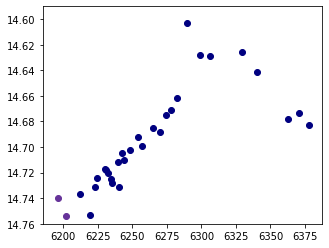

In [54]:
plt.figure(figsize=(5,4))
plt.scatter(sog4['MJD-50000'][478:507],sog4['I mag'][478:507],color='navy')
plt.scatter(sog4['MJD-50000'][476:478],sog4['I mag'][476:478],color='rebeccapurple')
#plt.scatter(sog4['MJD-50000'][507:510],sog4['I mag'][507:510],color='rebeccapurple')
plt.ylim(14.76,14.59)

In [55]:
centest = f.oneflareg(sog4,range(476,479),[507])
#only small reasonable test; no significant changes

st: 476 end: 507 cen: 6318.464448111999
st: 477 end: 507 cen: 6318.438168311585
st: 478 end: 507 cen: 6318.46915905181


In [56]:
centest = f.oneflareg(sog4,range(476,479),[507],det=True)

st: 476 end: 507 cen: 6319.104232430729
st: 477 end: 507 cen: 6319.078439305802
st: 478 end: 507 cen: 6319.114237318174


In [57]:
centest = f.oneflareg(sog4,range(476,479),[507],gline=True)
centest

array([[6309.52510292],
       [6309.52093885],
       [6309.55939557]])

In [58]:
centest = f.oneflareg(sog4,range(476,479),[507],gline=True,det=True)
centest

array([[6309.52510292],
       [6309.52093885],
       [6309.55939557]])

#### 6

In [59]:
flareinds[5]

[510, 536]

(14.71, 14.6)

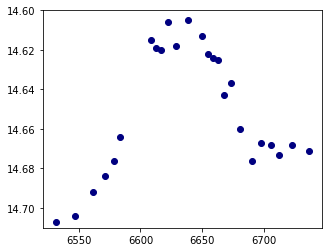

In [60]:
plt.figure(figsize=(5,4))
plt.scatter(sog4['MJD-50000'][510:536],sog4['I mag'][510:536],color='navy')
#currently using complete bounds, but can test last few points on each side
# plt.scatter(sog4['MJD-50000'][500:510],sog4['I mag'][500:510],color='rebeccapurple')
# plt.scatter(sog4['MJD-50000'][536:540],sog4['I mag'][536:540],color='rebeccapurple')
plt.ylim(14.71,14.6)

In [61]:
centest = f.oneflareg(sog4,range(510,512),range(530,536))
#two day range

st: 510 end: 530 cen: 6634.569204167396
st: 510 end: 531 cen: 6634.402558973583
st: 510 end: 532 cen: 6634.92400210686
st: 510 end: 533 cen: 6635.535504009804
st: 510 end: 534 cen: 6636.053726802969
st: 510 end: 535 cen: 6636.738048486762
st: 511 end: 530 cen: 6634.670317849142
st: 511 end: 531 cen: 6634.501699467003
st: 511 end: 532 cen: 6634.970428283808
st: 511 end: 533 cen: 6635.510703385516
st: 511 end: 534 cen: 6635.95720509607
st: 511 end: 535 cen: 6636.5333205149045


In [62]:
centest = f.oneflareg(sog4,range(510,512),range(530,536),det=True)

st: 510 end: 530 cen: 6633.694610343353
st: 510 end: 531 cen: 6633.491573221858
st: 510 end: 532 cen: 6633.895225277578
st: 510 end: 533 cen: 6634.358234052336
st: 510 end: 534 cen: 6634.727740390806
st: 510 end: 535 cen: 6635.195683546984
st: 511 end: 530 cen: 6633.796947757405
st: 511 end: 531 cen: 6633.593542344872
st: 511 end: 532 cen: 6633.950271815984
st: 511 end: 533 cen: 6634.350993682967
st: 511 end: 534 cen: 6634.659601344109
st: 511 end: 535 cen: 6635.039650310773


In [63]:
centest = f.oneflareg(sog4,range(510,512),range(530,536),gline=True)
centest
#six day range

array([[6634.59783154, 6635.65259415, 6632.09504109, 6630.8595942 ,
        6630.64557787, 6630.25750545],
       [6634.63267779, 6635.61660621, 6631.85573564, 6630.65075549,
        6630.44832884, 6630.10352024]])

In [64]:
centest = f.oneflareg(sog4,range(510,512),range(530,536),gline=True,det=True)
centest

array([[6634.59783154, 6635.65259415, 6632.09504109, 6630.8595942 ,
        6630.64557787, 6630.25750545],
       [6634.63267779, 6635.61660621, 6631.85573564, 6630.65075549,
        6630.44832884, 6630.10352024]])

#### 7

In [65]:
flareinds[6]

[540, 576]

(14.69, 14.54)

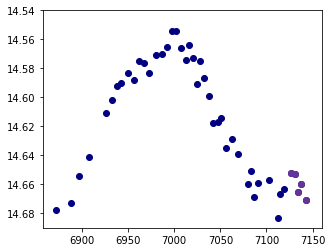

In [66]:
plt.figure(figsize=(5,4))
plt.scatter(sog4['MJD-50000'][540:585],sog4['I mag'][540:585],color='navy')
#currently using complete bounds, but can test last few points on each side
plt.scatter(sog4['MJD-50000'][580:585],sog4['I mag'][580:585],color='rebeccapurple')
#plt.scatter(sog4['MJD-50000'][536:540],sog4['I mag'][536:540],color='rebeccapurple')
plt.ylim(14.69,14.54)

In [67]:
centest = f.oneflareg(sog4,[540],range(576,585)) #one day

st: 540 end: 576 cen: 6988.882602599846
st: 540 end: 577 cen: 6988.957734702899
st: 540 end: 578 cen: 6988.86401640707
st: 540 end: 579 cen: 6988.903441148433
st: 540 end: 580 cen: 6988.962847815652
st: 540 end: 581 cen: 6989.058436438346
st: 540 end: 582 cen: 6989.142008884351
st: 540 end: 583 cen: 6989.184054982756
st: 540 end: 584 cen: 6989.23845281835


In [68]:
centest = f.oneflareg(sog4,[540],range(576,585),det=True) #one day; also systematically a day lower

st: 540 end: 576 cen: 6987.96795559328
st: 540 end: 577 cen: 6988.009316207603
st: 540 end: 578 cen: 6987.829630358199
st: 540 end: 579 cen: 6987.8622077709015
st: 540 end: 580 cen: 6987.91242900658
st: 540 end: 581 cen: 6987.995234272897
st: 540 end: 582 cen: 6988.065847381263
st: 540 end: 583 cen: 6988.097940669922
st: 540 end: 584 cen: 6988.140171171348


In [69]:
#four days
centest = f.oneflareg(sog4,[540],range(576,585),gline=True) 
centest

array([[6988.82717074, 6986.66437998, 6987.13940787, 6986.51912462,
        6986.00294043, 6985.32657441, 6984.87594884, 6984.80586197,
        6984.64862378]])

In [70]:
centest = f.oneflareg(sog4,[540],range(576,585),gline=True,det=True) 
centest

array([[6988.82717074, 6986.66437998, 6987.13940787, 6986.51912462,
        6986.00294043, 6985.32657441, 6984.87594884, 6984.80586197,
        6984.64862378]])

#### 8

In [71]:
flareinds[7]

[585, 600]

(14.74, 14.64)

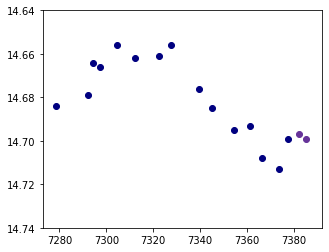

In [72]:
plt.figure(figsize=(5,4))
plt.scatter(sog4['MJD-50000'][585:600],sog4['I mag'][585:600],color='navy')
# plt.scatter(sog4['MJD-50000'][580:585],sog4['I mag'][580:585],color='rebeccapurple')
plt.scatter(sog4['MJD-50000'][600:602],sog4['I mag'][600:602],color='rebeccapurple')
plt.ylim(14.74,14.64)

In [73]:
centest = f.oneflareg(sog4,[585],range(597,602))

st: 585 end: 597 cen: 7313.669136140674
st: 585 end: 598 cen: 7313.716271353156
st: 585 end: 599 cen: 7313.749879879371
st: 585 end: 600 cen: 7313.795244152553
st: 585 end: 601 cen: 7313.798080674851


In [74]:
centest = f.oneflareg(sog4,[585],range(597,602),det=True)

st: 585 end: 597 cen: 7312.34768702222
st: 585 end: 598 cen: 7312.334103291481
st: 585 end: 599 cen: 7312.372488863716
st: 585 end: 600 cen: 7312.371070151014
st: 585 end: 601 cen: 7312.307526498406


In [75]:
centest = f.oneflareg(sog4,[585],range(597,602),gline=True)
centest

array([[7315.59950837, 7316.87392137, 7317.2806244 , 7316.45798414,
        7315.57275424]])

In [76]:
centest = f.oneflareg(sog4,[585],range(597,602),gline=True,det=True)
centest

array([[7315.59950837, 7316.87392137, 7317.2806244 , 7316.45798414,
        7315.57275424]])

#### 9

In [77]:
flareinds[8]

[600, 630]

(14.74, 14.6)

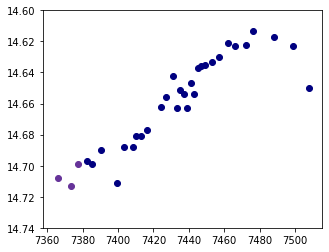

In [78]:
plt.figure(figsize=(5,4))
plt.scatter(sog4['MJD-50000'][600:630],sog4['I mag'][600:630],color='navy')
plt.scatter(sog4['MJD-50000'][597:600],sog4['I mag'][597:600],color='rebeccapurple')
# plt.scatter(sog4['MJD-50000'][600:602],sog4['I mag'][600:602],color='rebeccapurple')
plt.ylim(14.74,14.6)

In [79]:
centest = f.oneflareg(sog4,range(597,602),[630])

st: 597 end: 630 cen: 7477.189289417515
st: 598 end: 630 cen: 7477.169240737321
st: 599 end: 630 cen: 7477.118612800186
st: 600 end: 630 cen: 7476.981892191036
st: 601 end: 630 cen: 7476.828419346315


In [80]:
centest = f.oneflareg(sog4,range(597,602),[630],det=True)

st: 597 end: 630 cen: 7478.474672101164
st: 598 end: 630 cen: 7478.458819827429
st: 599 end: 630 cen: 7478.255841788823
st: 600 end: 630 cen: 7478.1380862076285
st: 601 end: 630 cen: 7477.992857802242


#### 10

In [81]:
flareinds[9]

[630, 660]

(14.74, 14.58)

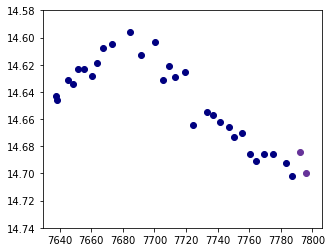

In [82]:
plt.figure(figsize=(5,4))
plt.scatter(sog4['MJD-50000'][630:660],sog4['I mag'][630:660],color='navy')
# plt.scatter(sog4['MJD-50000'][625:630],sog4['I mag'][625:630],color='rebeccapurple')
plt.scatter(sog4['MJD-50000'][660:662],sog4['I mag'][660:662],color='rebeccapurple')
plt.ylim(14.74,14.58)

In [83]:
centest = f.oneflareg(sog4,[630],range(658,662))

st: 630 end: 658 cen: 7681.757078698369
st: 630 end: 659 cen: 7681.785868269432
st: 630 end: 660 cen: 7682.035390620263
st: 630 end: 661 cen: 7682.0029202739715


In [84]:
centest = f.oneflareg(sog4,[630],range(658,662),det=True)

st: 630 end: 658 cen: 7682.395595007957
st: 630 end: 659 cen: 7682.394772618848
st: 630 end: 660 cen: 7682.6472627119465
st: 630 end: 661 cen: 7682.6314149235905


#### 11

In [85]:
flareinds[10]

[671, 700]

(14.74, 14.58)

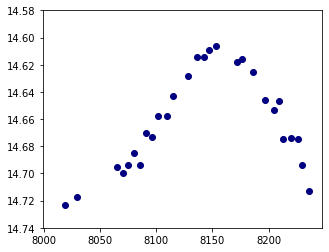

In [86]:
plt.figure(figsize=(5,4))
plt.scatter(sog4['MJD-50000'][671:700],sog4['I mag'][671:700],color='navy')
# plt.scatter(sog4['MJD-50000'][665:671],sog4['I mag'][665:671],color='rebeccapurple')
# plt.scatter(sog4['MJD-50000'][700:705],sog4['I mag'][700:705],color='rebeccapurple')
plt.ylim(14.74,14.58)
#can just test first few points

In [87]:
centest = f.oneflareg(sog4,[671,672,673],[700])

st: 671 end: 700 cen: 8155.107213528134
st: 672 end: 700 cen: 8155.783209280312
st: 673 end: 700 cen: 8155.974269115075


In [88]:
centest = f.oneflareg(sog4,[671,672,673],[700],gline=True)
centest #failed for last one; could update guesses if needed 

array([[8162.56641566],
       [8162.39976783],
       [8223.35518023]])

#### 12

In [89]:
flareinds[11]

[711, 738]

(14.74, 14.58)

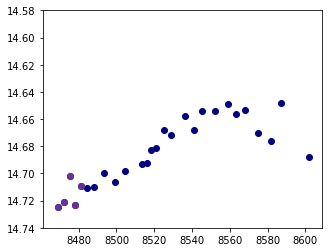

In [90]:
plt.figure(figsize=(5,4))
plt.scatter(sog4['MJD-50000'][711:738],sog4['I mag'][711:738],color='navy')
plt.scatter(sog4['MJD-50000'][711:716],sog4['I mag'][711:716],color='rebeccapurple')
# plt.scatter(sog4['MJD-50000'][738:740],sog4['I mag'][738:740],color='rebeccapurple')
plt.ylim(14.74,14.58)


In [91]:
centest = f.oneflareg(sog4,range(711,716),[738])


st: 711 end: 738 cen: 8559.433757789124
st: 712 end: 738 cen: 8559.44355715129
st: 713 end: 738 cen: 8559.49599592802
st: 714 end: 738 cen: 8559.321922836385
st: 715 end: 738 cen: 8559.254111652066


In [92]:
centest = f.oneflareg(sog4,range(711,716),[738],det=True)

st: 711 end: 738 cen: 8560.791205883019
st: 712 end: 738 cen: 8560.784069520369
st: 713 end: 738 cen: 8560.86027920674
st: 714 end: 738 cen: 8560.664751425362
st: 715 end: 738 cen: 8560.583065229748


#### 13

In [93]:
flareinds[12]

[738, 758]

(14.78, 14.58)

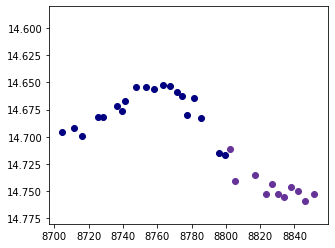

In [94]:
plt.figure(figsize=(5,4))
plt.scatter(sog4['MJD-50000'][738:758],sog4['I mag'][738:758],color='navy')
plt.scatter(sog4['MJD-50000'][758:769],sog4['I mag'][758:769],color='rebeccapurple')
# plt.scatter(sog4['MJD-50000'][738:740],sog4['I mag'][738:740],color='rebeccapurple')
plt.ylim(14.78,14.58)

In [95]:
centest = f.oneflareg(sog4,[738],range(758,769))
#two days

st: 738 end: 758 cen: 8755.943745124776
st: 738 end: 759 cen: 8755.848152005969
st: 738 end: 760 cen: 8753.90260674883
st: 738 end: 761 cen: 8753.856724332887
st: 738 end: 762 cen: 8753.409228737513
st: 738 end: 763 cen: 8753.40793589129
st: 738 end: 764 cen: 8753.387094041285
st: 738 end: 765 cen: 8753.338103378905
st: 738 end: 766 cen: 8753.340596876793
st: 738 end: 767 cen: 8753.340760005718
st: 738 end: 768 cen: 8753.282994235304


In [96]:
centest = f.oneflareg(sog4,[738],range(758,769),det=True)
#three days; couple days higher than original data center

st: 738 end: 758 cen: 8757.249225196212
st: 738 end: 759 cen: 8757.174810603672
st: 738 end: 760 cen: 8755.218537937732
st: 738 end: 761 cen: 8755.175789485913
st: 738 end: 762 cen: 8754.69443845122
st: 738 end: 763 cen: 8754.697540115983
st: 738 end: 764 cen: 8754.672837152386
st: 738 end: 765 cen: 8754.632651091519
st: 738 end: 766 cen: 8754.638582980262
st: 738 end: 767 cen: 8754.639993575302
st: 738 end: 768 cen: 8754.588093588021


In [97]:
centest = f.oneflareg(sog4,[738],range(758,769),gline=True)
centest #five day range; all higher than gaussain centers

array([[8766.88472364, 8763.30392079, 8767.03108275, 8763.30661499,
        8763.83151803, 8763.28397955, 8763.36604197, 8763.40352112,
        8763.099698  , 8762.94638809, 8763.00866407]])

In [98]:
centest = f.oneflareg(sog4,[738],range(758,769),gline=True,det=True)
centest #five day range; all higher than gaussain centers

array([[8766.88472364, 8763.30392079, 8767.03108275, 8763.30661499,
        8763.83151803, 8763.28397955, 8763.36604197, 8763.40352112,
        8763.099698  , 8762.94638809, 8763.00866407]])

> summary: changes in data inclusion when it comes to the gaussian-based models results in center differences of up to ~6 days. for most flares, there is a clear range of data and/or the variation is two days at most. can compile hist based on this variable if needed, but it's clear that the variation from model choice generally overshadows this effect.

# 6. Bootstrapping Gaussian

#### first flare
- used for hist comparing to corresponding triangle results


In [99]:
reload(f)
#100 bootstrap iterations on first flare
#40-130
bsouts1,bsfits1 = f.bootg(sog4,flareinds,0)

In [100]:
#repeat with other indices for first flare
#40-150
bsouts2,bsfits2 = f.bootg(sog4,flareinds,0,end=150,indiv=True)

In [101]:
#50-130
bsouts3,bsfits3 = f.bootg(sog4,flareinds,0,st=50,indiv=True)

#### remaining flares

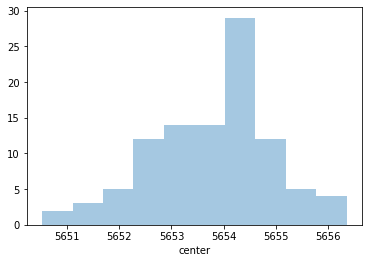

In [102]:
#follow this naming scheme for the remaining flares
import seaborn as sb
bsg2, bsf2 = f.bootg(sog4,flareinds,1)
a = sb.distplot(bsf2['center'],kde=False)

(array([ 1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0., 98.]),
 array([5012.72148776, 5092.19040148, 5171.6593152 , 5251.12822892,
        5330.59714264, 5410.06605636, 5489.53497008, 5569.0038838 ,
        5648.47279752, 5727.94171124, 5807.41062496]),
 <a list of 10 Patch objects>)

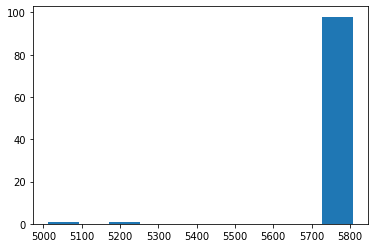

In [103]:
bsg3, bsf3 = f.bootg(sog4,flareinds,2)
plt.hist(bsf3['center'])

In [104]:
#bsg3, bsf3 = f.bootg(sog4,flareinds,2)
bsg4, bsf4 = f.bootg(sog4,flareinds,3)
bsg5, bsf5 = f.bootg(sog4,flareinds,4)
bsg6, bsf6 = f.bootg(sog4,flareinds,5)
bsg7, bsf7 = f.bootg(sog4,flareinds,6)

In [105]:
bsg8, bsf8 = f.bootg(sog4,flareinds,7)
bsg9, bsf9 = f.bootg(sog4,flareinds,8)
bsg10, bsf10 = f.bootg(sog4,flareinds,9)
bsg11, bsf11 = f.bootg(sog4,flareinds,10)
bsg12, bsf12 = f.bootg(sog4,flareinds,11)
bsg13, bsf13 = f.bootg(sog4,flareinds,12)

In [106]:
#list of DataFrames from gaussian bootstrapping; no offset; original data
gbs = [bsf2,bsf3,bsf4,bsf5,bsf6,bsf7,bsf8,bsf9,bsf10,bsf11,bsf12,bsf13]

In [107]:
bsfits1['center'].describe()

count     100.000000
mean     5497.311416
std         1.565609
min      5493.614404
25%      5496.318579
50%      5497.204325
75%      5498.393462
max      5500.935170
Name: center, dtype: float64

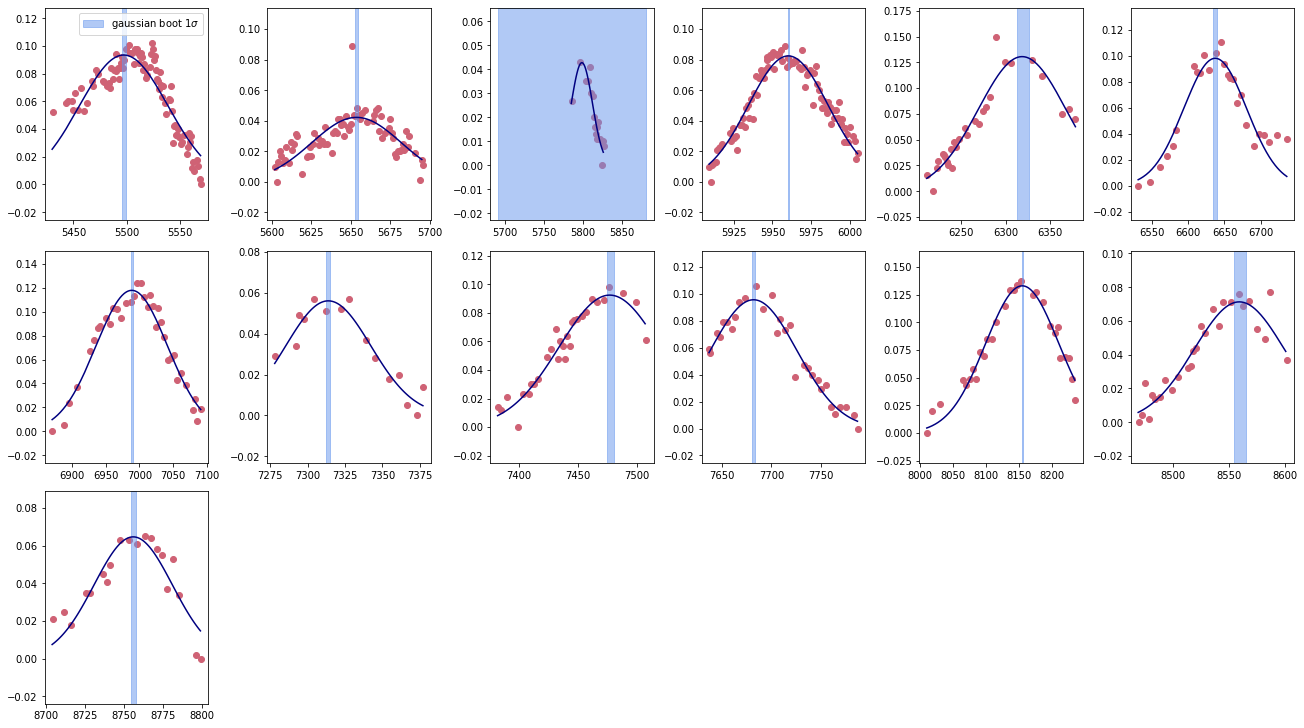

In [108]:
#13 flares with gaussian fit and one sigma from bootstrapping
fig = plt.figure(constrained_layout=True,figsize=(18,10))
gs = fig.add_gridspec(3,6)
for g in range(13):
    if g < 6: axt = fig.add_subplot(gs[0, g])
    elif g < 12: axt = fig.add_subplot(gs[1, g-6])
    else: axt = fig.add_subplot(gs[2, g-12])
    st = flareinds[g][0]
    end = flareinds[g][1]
    stdate = int(sog4['MJD-50000'][st:st+1])
    enddate = int(sog4['MJD-50000'][end-1:end])
    axt.scatter(sog4['MJD-50000'][st:end],np.max(sog4['I mag'][st:end])-sog4['I mag'][st:end],color='#CF6275')
    if g == 0:
        axt.axvspan(np.mean(bsfits1['center'])-np.std(bsfits1['center']),np.mean(bsfits1['center'])+np.std(bsfits1['center']),color='cornflowerblue',alpha=.5,label='gaussian boot 1$\sigma$')
        axt.legend()
    else:
        axt.axvspan(np.mean(gbs[g-1]['center'])-np.std(gbs[g-1]['center']),np.mean(gbs[g-1]['center'])+np.std(gbs[g-1]['center']),color='cornflowerblue',alpha=.5)
    #plot gaussian
    xfits = np.linspace(enddate,stdate,enddate-stdate)
    bfit = f.gaussian(xfits,gout[g].best_values['amplitude'],gout[g].best_values['center'],gout[g].best_values['sigma'])
    axt.plot(xfits,bfit,color='navy')
png('gaussianboot')

# 7. Sinusoidal Model

In [109]:
sin_inds = [[40,150]]+flareinds[1:]

In [110]:
#save sine fits on original and detrended data
reload(f)
sinmods = []
sinmdet = []
for s in sin_inds:
    st = s[0]
    end = s[1]
    res = f.fit_sin(sog4['MJD-50000'][st:end],sog4['I mag'][st:end])
    resd = f.fit_sin(sog4['MJD-50000'][st:end],sog4['I detrend 2'][st:end])
    sinmdet.append(resd)
    sinmods.append(res)

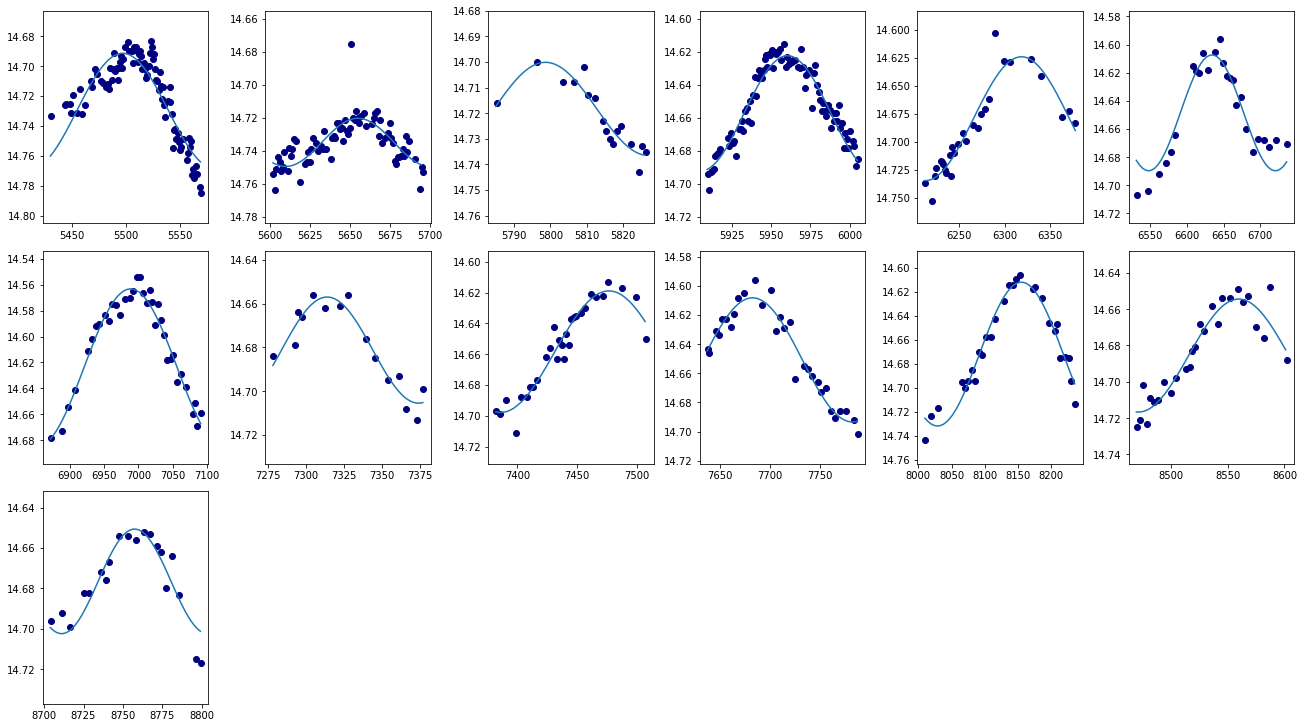

In [111]:
fig = plt.figure(constrained_layout=True,figsize=(18,10))
gs = fig.add_gridspec(3,6)
for g in range(13):
    if g < 6: axt = fig.add_subplot(gs[0, g])
    elif g < 12: axt = fig.add_subplot(gs[1, g-6])
    else: axt = fig.add_subplot(gs[2, g-12])
    st = flareinds[g][0]
    end = flareinds[g][1]
    stdate = int(sog4['MJD-50000'][st:st+1])
    enddate = int(sog4['MJD-50000'][end-1:end])
    axt.scatter(sog4['MJD-50000'][st:end],sog4['I mag'][st:end],color='navy')
    axt.plot(np.linspace(stdate,enddate),sinmods[g]["fitfunc"](np.linspace(stdate,enddate)))
    #axt.plot(sog4['MJD-50000'][st:end],sinmdet[f]["fitfunc"](sog4['MJD-50000'][st:end]),color='rebeccapurple',alpha=.6)

    axt.set_ylim(np.max(sog4['I mag'][st:end])+.02,np.min(sog4['I mag'][st:end])-.02)

In [112]:
#find peaks = centers of each
reload(f)
sincenters = []
for i in range(13):
     sincenters.append(f.peakplot(sog4,flareinds,sinmods,i,plot=False))
sincenters #differ from original guassian by no more than three days

[5497.000000000244,
 5655.100000000193,
 5798.70000000005,
 5960.300000000187,
 6318.500000000387,
 6634.200000000375,
 6988.400000000427,
 7313.80000000013,
 7476.7000000003445,
 7682.200000000164,
 8154.900000000527,
 8559.50000000033,
 8757.400000000194]

In [113]:
sincenters - gcenters

array([-0.02562862,  1.37833519,  0.10745108,  0.04906192,  0.03084095,
       -3.09443862, -0.4826026 ,  0.00475585, -0.28189219,  0.16460938,
       -0.20721353,  0.06624221,  1.45625488])

# 8. Triangle Model
- fit to each flare; show effect of initial split and start and end indices
- look at resulting hists and stdevs

- use 3D grids with initial split, st, end indices and show span of centers

5516.464172846205

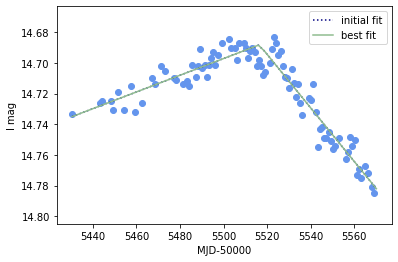

In [114]:
reload(f)
from scipy.optimize import curve_fit

f.triangfit(sog4,flareinds,0)

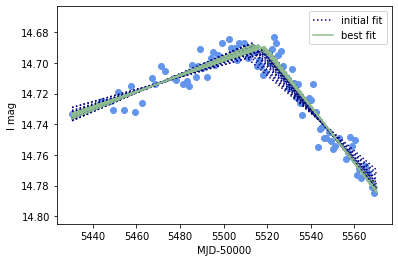

In [115]:
#changing split point
reload(f)
divcen1,divc1,divr1 = f.triangfit(sog4,flareinds,0,mult=True,rs=np.arange(-20,14,2),chis=True)
png('initsens')

In [116]:
divcen1

[5514.842777665542,
 5514.842771299237,
 5514.842773829969,
 5514.842769786875,
 5514.8427698671585,
 5514.842771636243,
 5514.842769213695,
 5514.8427778827945,
 5514.842770288234,
 5514.842772750654,
 5516.464172846205,
 5518.606558277271,
 5519.697942707114,
 5519.697948121864,
 5518.606556130424,
 5517.356573777751,
 5518.60655940055]

(14.8, 14.66)

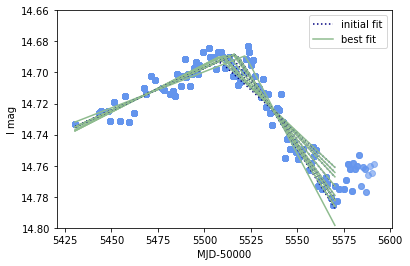

In [117]:
endcen1,endc1,endr1 = f.triangfit(sog4,flareinds,0,mult=True,off=True,rs=np.arange(-20,20,4),chis=True)
plt.ylim(14.8,14.66)

(14.8, 14.66)

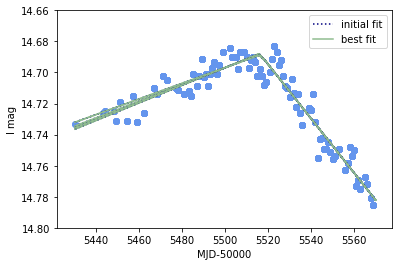

In [118]:
stcen1,stc1,str1 = f.triangfit(sog4,flareinds,0,mult=True,off=True,stcut=True,rs=np.arange(0,10),chis=True)
plt.ylim(14.8,14.66)

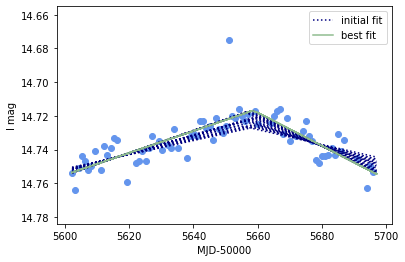

In [119]:
#second flare: different splits
divcen2,divc2,divr2 = f.triangfit(sog4,flareinds,1,mult=True,rs=np.arange(-10,10),chis=True)

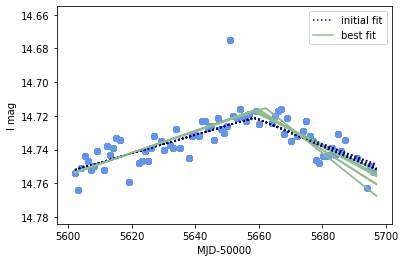

In [120]:
#also checked start data -- stays at 5654
#cutting off points from right
endcen2,endc2,endr2 = f.triangfit(sog4,flareinds,1,mult=True,off=True,rs=np.arange(0,10),chis=True)

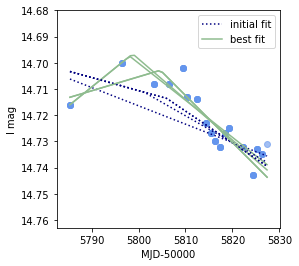

In [121]:
#different numbers of final points
#this flare needs div moved 
plt.figure(figsize=(4,4))
endcen3,endc3,endr3 = f.triangfit(sog4,flareinds,2,div=2,mult=True,off=True,rs=np.arange(-1,2),chis=True)

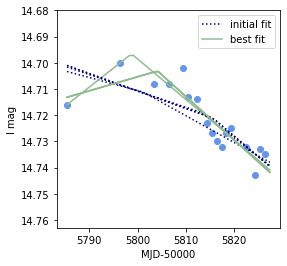

In [122]:
#different split points
#generally getting rid of obviously wrong fits
plt.figure(figsize=(4,4))
divcen3,divc3,divr3 = f.triangfit(sog4,flareinds,2,mult=True,rs=np.arange(2,5),chis=True)

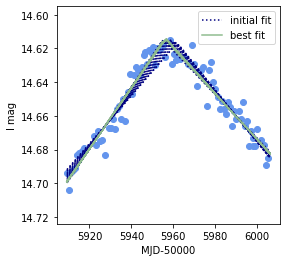

In [123]:
#fourth flare
#location of split
plt.figure(figsize=(4,4))
divcen4,divc4,divr4 = f.triangfit(sog4,flareinds,3,mult=True,rs=np.arange(-5,10),chis=True)

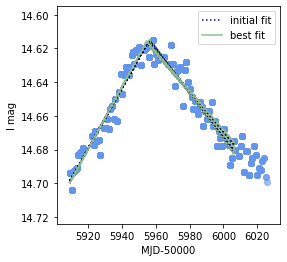

In [124]:
#fourth flare different data inclusion
plt.figure(figsize=(4,4))
endcen4,endc4,endr4 = f.triangfit(sog4,flareinds,3,mult=True,off=True,rs=np.arange(-20,20),chis=True)

(14.72, 14.6)

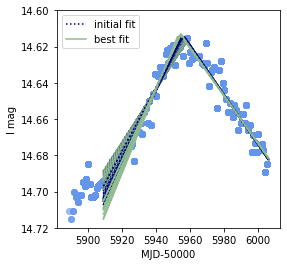

In [125]:
#checking start of flare data changes
#fourth flare different data inclusion
plt.figure(figsize=(4,4))
stcen4,stc4,str4 = f.triangfit(sog4,flareinds,3,mult=True,off=True,stcut=True,rs=np.arange(-20,20),chis=True) 

plt.ylim(14.72,14.6)

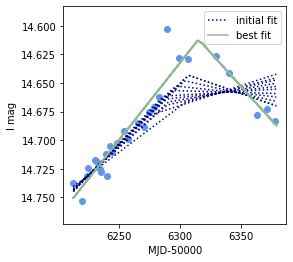

In [126]:
#fifth flare split
plt.figure(figsize=(4,4))
divcen5,divc5,divr5 = f.triangfit(sog4,flareinds,4,mult=True,rs=np.arange(-4,6),chis=True)

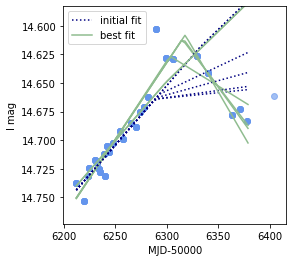

In [127]:
#data inclusion; small for stcut if you don't add data
plt.figure(figsize=(4,4))
endcen5,endc5,endr5 = f.triangfit(sog4,flareinds,4,mult=True,off=True,rs=np.arange(-1,4),chis=True) 
#lower than gaussian value

In [128]:
endcen5

[6303.23618456582,
 6315.209439944601,
 6315.8626220476135,
 6318.030718733536,
 6299.281579851758]

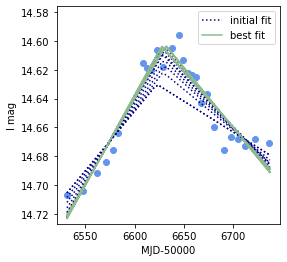

In [129]:
#moving split
plt.figure(figsize=(4,4))
divcen6,divc6,divr6 = f.triangfit(sog4,flareinds,5,mult=True,rs=np.arange(-5,5),chis=True) 
#lower than gaussian value

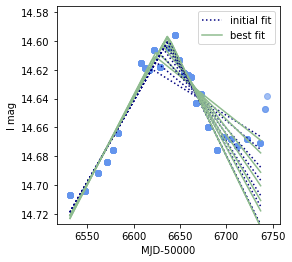

In [130]:
plt.figure(figsize=(4,4))
endcen6,endc6,endr6 = f.triangfit(sog4,flareinds,5,mult=True,off=True,rs=np.arange(-2,5),chis=True)

(14.74, 14.58)

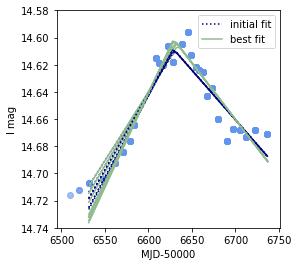

In [131]:
plt.figure(figsize=(4,4))
stcen6,stc6,str6 = f.triangfit(sog4,flareinds,5,mult=True,off=True,stcut=True,rs=np.arange(-2,5),chis=True) 
plt.ylim(14.74,14.58)

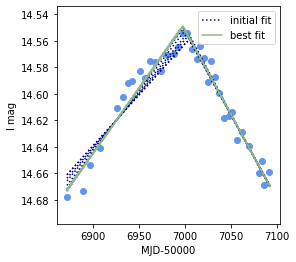

In [132]:
plt.figure(figsize=(4,4))
divcen7,divc7,divr7 = f.triangfit(sog4,flareinds,6,mult=True,rs=np.arange(-2,5),chis=True)

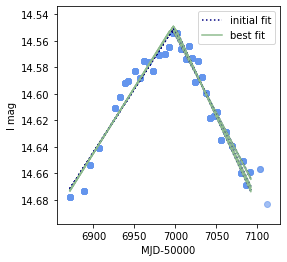

In [133]:
plt.figure(figsize=(4,4))
endcen7,endc7,endr7 = f.triangfit(sog4,flareinds,6,mult=True,off=True,rs=np.arange(-2,5),chis=True)

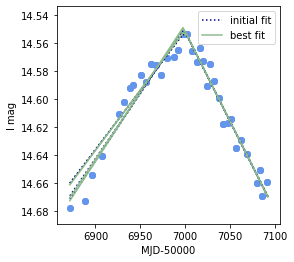

In [134]:
plt.figure(figsize=(4,4))
stcen7,stc7,str7 = f.triangfit(sog4,flareinds,6,mult=True,off=True,stcut=True,rs=np.arange(0,3),chis=True)

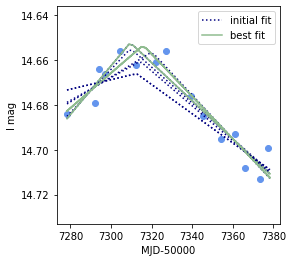

In [135]:
plt.figure(figsize=(4,4))
divcen8,divc8,divr8 = f.triangfit(sog4,flareinds,7,mult=True,rs=np.arange(-3,3),chis=True)

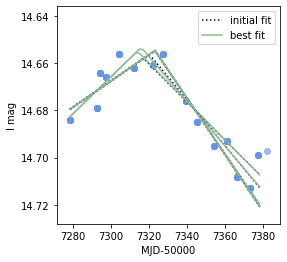

In [136]:
plt.figure(figsize=(4,4))
endcen8,endc8,endr8 = f.triangfit(sog4,flareinds,7,mult=True,off=True,rs=np.arange(-1,3),chis=True)

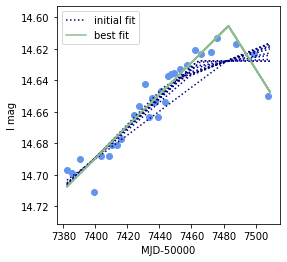

In [137]:
plt.figure(figsize=(4,4))
divcen9,divc9,divr9 = f.triangfit(sog4,flareinds,8,mult=True,rs=np.arange(-5,5),chis=True)

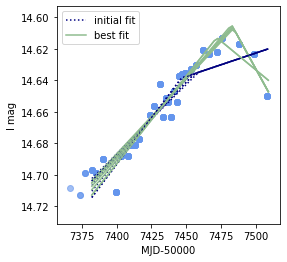

In [138]:
plt.figure(figsize=(4,4))
stcen9,stc9,str9 = f.triangfit(sog4,flareinds,8,mult=True,off=True,stcut=True,rs=np.arange(-3,3),chis=True)

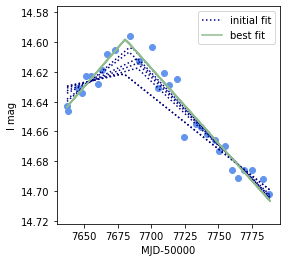

In [139]:
plt.figure(figsize=(4,4))
divcen10,divc10,divr10 = f.triangfit(sog4,flareinds,9,mult=True,rs=np.arange(-3,3),chis=True)

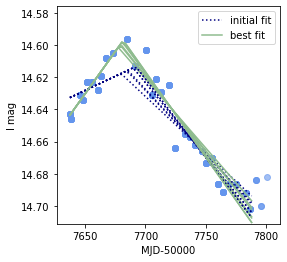

In [140]:
plt.figure(figsize=(4,4))
endcen10,endc10,endr10 = f.triangfit(sog4,flareinds,9,mult=True,off=True,rs=np.arange(-3,3),chis=True)

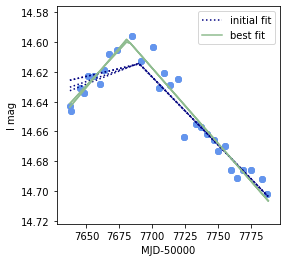

In [141]:
plt.figure(figsize=(4,4))
stcen10,stc10,str10 = f.triangfit(sog4,flareinds,9,mult=True,off=True,stcut=True,rs=np.arange(3),chis=True)


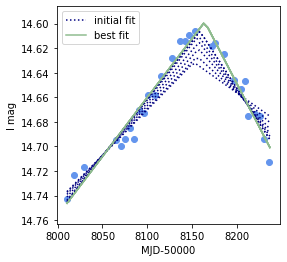

In [142]:
plt.figure(figsize=(4,4))
divcen11,divc11,divr11 = f.triangfit(sog4,flareinds,10,mult=True,rs=np.arange(-3,3),chis=True)

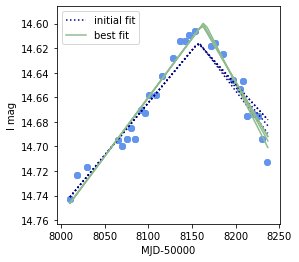

In [143]:
plt.figure(figsize=(4,4))
endcen11,endc11,endr11 = f.triangfit(sog4,flareinds,10,mult=True,off=True,rs=np.arange(0,3),chis=True)

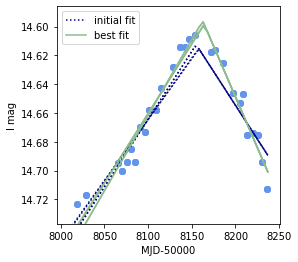

In [144]:
plt.figure(figsize=(4,4))
stcen11,stc11,str11 = f.triangfit(sog4,flareinds,10,mult=True,off=True,stcut=True,rs=np.arange(3),chis=True) 


In [145]:
stcen11

[8164.304913488089, 8164.0576366347805, 8162.483679000762]

In [146]:
endcen11

[8164.304913488089, 8162.825317079806, 8161.888685152663]

In [147]:
glcenters[10]

8162.566418416636

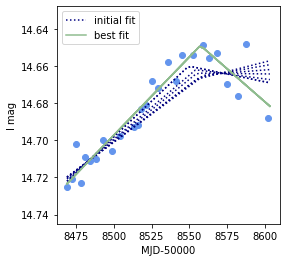

In [148]:
plt.figure(figsize=(4,4))
divcen12,divc12,divr12 = f.triangfit(sog4,flareinds,11,mult=True,rs=np.arange(-3,3),chis=True)

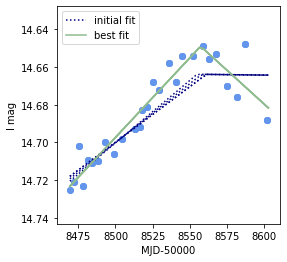

In [149]:
plt.figure(figsize=(4,4))
stcen12,stc12,str12 = f.triangfit(sog4,flareinds,11,mult=True,off=True,stcut=True,rs=np.arange(3),chis=True)

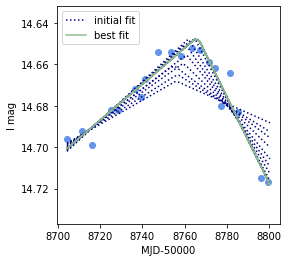

In [150]:
#last flare!
plt.figure(figsize=(4,4))
divcen13,divc13,divr13 = f.triangfit(sog4,flareinds,12,mult=True,rs=np.arange(-6,3),chis=True)

(14.76, 14.64)

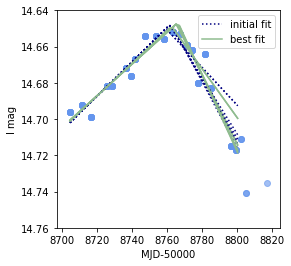

In [151]:
plt.figure(figsize=(4,4))
endcen13,endc13,endr13 = f.triangfit(sog4,flareinds,12,mult=True,off=True,rs=np.arange(-3,3),chis=True) 

plt.ylim(14.76,14.64)

(14.74, 14.64)

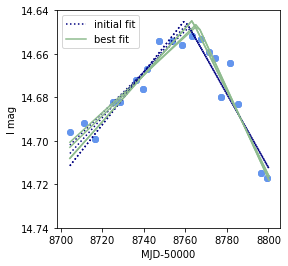

In [152]:
plt.figure(figsize=(4,4))
stcen13,stc13,str13 = f.triangfit(sog4,flareinds,12,mult=True,off=True,stcut=True,rs=np.arange(0,3),chis=True) 
plt.ylim(14.74,14.64)

4.288576126898216
1.1464273513184142
2.940466968037542
0.5169685413704393
7.564516396655148
5.266654923372255
1.1663521403648562
4.1681603991997305
1.416347153539276
0.9946883524928747
1.2677953132272177


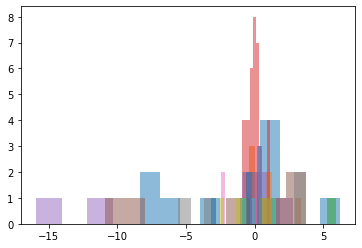

In [153]:
#looking at hist of changes and stdevs based on changing end indices
a = plt.hist(endcen1-np.median(endcen1),alpha=.5)
print(np.std(endcen1))
a = plt.hist(endcen2-np.median(endcen2),alpha=.5)
print(np.std(endcen2))
a = plt.hist(endcen3-np.median(endcen3),alpha=.5)
print(np.std(endcen3))
a = plt.hist(endcen4-np.median(endcen4),alpha=.5)
print(np.std(endcen4))
a = plt.hist(endcen5-np.median(endcen5),alpha=.5)
print(np.std(endcen5))
a = plt.hist(endcen6-np.median(endcen6),alpha=.5)
print(np.std(endcen6))
a = plt.hist(endcen7-np.median(endcen7),alpha=.5)
print(np.std(endcen7))
a = plt.hist(endcen8-np.median(endcen8),alpha=.5)
print(np.std(endcen8))
a = plt.hist(endcen10-np.median(endcen10),alpha=.5)
print(np.std(endcen10))
a = plt.hist(endcen11-np.median(endcen11),alpha=.5)
print(np.std(endcen11))
# a = plt.hist(endcen12-np.median(endcen12))
# print(np.std(endcen12))
a = plt.hist(endcen13-np.median(endcen13),alpha=.5)
print(np.std(endcen13))


0.1327241861071328
1.4379509493449232
1.846299191273263
0.7693357624407191
4.272140757377689
0.4235534704591858
0.8065966590625149
1.211127148754482


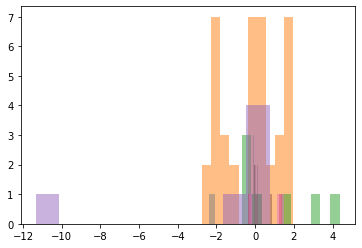

In [154]:
#looking at hist of changes and stdevs based on changing start indices
a = plt.hist(stcen1-np.median(stcen1),alpha=.5)
print(np.std(stcen1))

a = plt.hist(stcen4-np.median(stcen4),alpha=.5)
print(np.std(stcen4))
a = plt.hist(stcen6-np.median(stcen6),alpha=.5)
print(np.std(stcen6))
a = plt.hist(stcen7-np.median(stcen7),alpha=.5)
print(np.std(stcen7))
a = plt.hist(stcen9-np.median(stcen9),alpha=.5)
print(np.std(stcen9))
a = plt.hist(stcen10-np.median(stcen10),alpha=.5)
print(np.std(stcen10))
a = plt.hist(stcen11-np.median(endcen11),alpha=.5)
print(np.std(stcen11))
# a = plt.hist(endcen12-np.median(endcen12))
# print(np.std(endcen12))
a = plt.hist(stcen13-np.median(stcen13),alpha=.5)
print(np.std(stcen13))


#### 3D grids

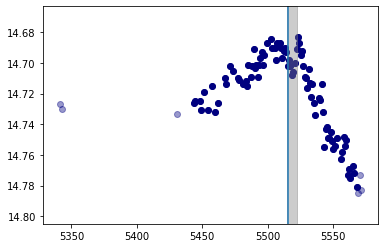

In [155]:
reload(f)
f1,r1,lc1 = f.tp(sog4,flareinds,0)

- may be including too much information but it's nice to check the interplay between these variables
- in this example, we can see that initial range was too large at the start and too small at the end


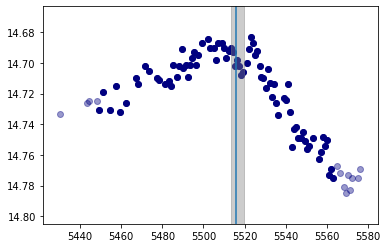

In [156]:
f1,r1,lc1 = f.tp(sog4,flareinds,0,cut1=range(0,5),cut2=range(-5,5))

In [157]:
#average along min axis
endf1 = np.mean(f1,axis=2)
endf1 = np.mean(endf1,axis=0)
endf1

array([5513.45134944, 5514.03171201, 5516.13878412, 5517.09097698,
       5516.51471777, 5516.80326784, 5515.93594595, 5515.34100421,
       5515.06858805, 5515.19417561])

In [158]:
#from when end index was larger
f1_cut,r1_cut,lc1_cut = f1,r1,lc1

#### saving means of 3D grids for histogram

In [159]:
#save f1_cut mean for histogram
trimeans = [] 
trimeans.append(np.mean(f1_cut))
trimeans #much higher than gaussian value

[5515.557052198727]

In [160]:
#will plot all flares together so no need to plot any more individually
f2,r2 = f.tri3D(sog4,flareinds,1,cut2=range(5))
trimeans.append(np.mean(f2))

In [161]:
f3,r3 = f.tri3D(sog4,flareinds,2,cut1=[0],cut2=[0],div=range(2,5))
trimeans.append(np.mean(f3))

[-1.45429029e-03  2.31296593e+01  1.54831758e-03  5.71829080e+00]
5798.748712773488
[-5.35256696e-04  1.78098491e+01  1.66490008e-03  5.03982789e+00]
5804.141487937649
[-5.35262153e-04  1.78098807e+01  1.66490007e-03  5.03982794e+00]
5804.141465378281


In [162]:
f4,r4 = f.tri3D(sog4,flareinds,3)
trimeans.append(np.mean(f4))
f5,r5 = f.tri3D(sog4,flareinds,4)
trimeans.append(np.mean(f5))
f6,r6 = f.tri3D(sog4,flareinds,5,cut2=range(4)) #doesn't include points obviously going up
trimeans.append(np.mean(f6))

In [163]:
f7,r7 = f.tri3D(sog4,flareinds,6,cut1=range(0,4),cut2=range(0,8))
trimeans.append(np.mean(f7))

In [164]:
f8,r8 = f.tri3D(sog4,flareinds,7,cut2=range(2),div=range(4)) 
trimeans.append(np.mean(f8))
f9,r9 = f.tri3D(sog4,flareinds,8,cut1=range(-4,6),cut2=[0]) 
trimeans.append(np.mean(f9))

In [165]:
f10,r10 = f.tri3D(sog4,flareinds,9,cut1=[0,1,2])
trimeans.append(np.mean(f10))
f11,r11 = f.tri3D(sog4,flareinds,10,cut1=range(0,5),cut2=range(3)) 
trimeans.append(np.mean(f11))

In [166]:
f12,r12 = f.tri3D(sog4,flareinds,11,cut1=range(4),cut2=[0])
trimeans.append(np.mean(f12))

In [167]:
f13,r13 = f.tri3D(sog4,flareinds,12,cut1=range(2)) 
trimeans.append(np.mean(f13))

In [168]:
hist_gtcens = np.concatenate((hist_gcens,[np.array(trimeans)]))

5.688544459424129

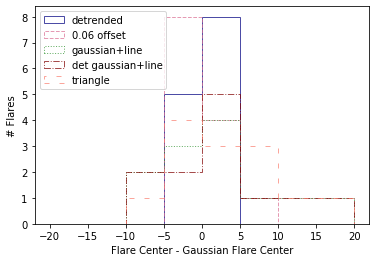

In [169]:
#histogram comparing centers to the simplest 0 offset gaussian model on the original data
#colors are by model, and do not show individual flares; colors different from above sine only showing one extra offset

#add triangle to hist (update labels as well)
reload(f)
#works with default labels here
f.flarehist(hist_gtcens,gcenters)
#prints standard deviation
#png('flarehist2')

# 9. Bootstrapping Triangle Model

In [170]:
reload(f)
bs1_100 = f.bstri(sog4,flareinds,0,indiv=True,num=100)

In [171]:
#for hist comparing to gaussian sensitivity
bs1_50 = f.bstri(sog4,flareinds,0,si=50,indiv=True,num=100)
bs1_150 = f.bstri(sog4,flareinds,0,ei=150,indiv=True,num=100)

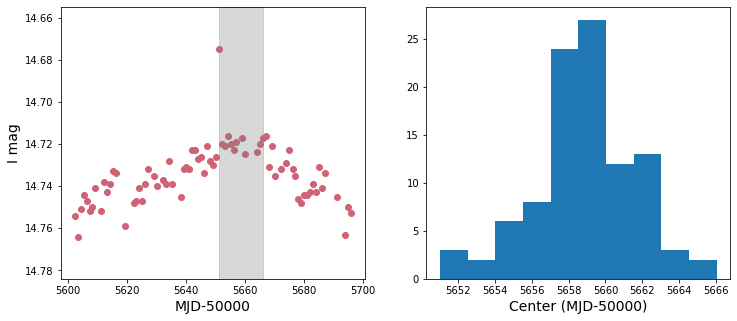

In [172]:
#sometimes get outlier results, though (~5620)
#bootstrap and plot
bs2 = f.bstri(sog4,flareinds,1,num=100)
f.plbs(sog4,flareinds,bs2,1)

In [173]:
#bp_list: list of bootstrap results; just taking original inds for first
bp_list = [bs1_100,bs2]
bsp = f.bstri(sog4,flareinds,2,num=100,sp_off=-4)
bp_list.append(bsp)

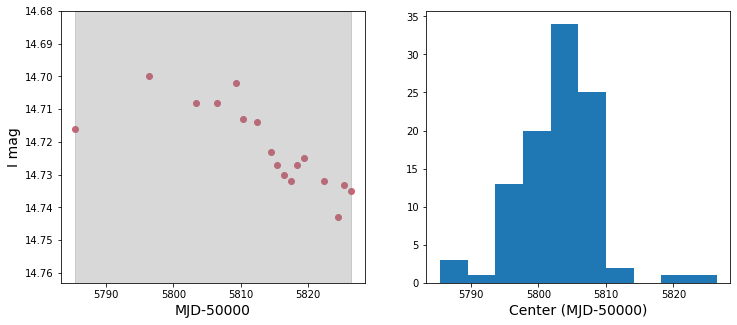

In [174]:
f.plbs(sog4,flareinds,bsp,2) #bootstrapping tricky with this flare

In [175]:
bsp = f.bstri(sog4,flareinds,3,num=100)
bp_list.append(bsp)

In [176]:
bsp = f.bstri(sog4,flareinds,4,num=100)
bp_list.append(bsp)
bsp = f.bstri(sog4,flareinds,5,num=100)
bp_list.append(bsp)
bsp = f.bstri(sog4,flareinds,6,num=100)
bp_list.append(bsp)

In [177]:
bsp = f.bstri(sog4,flareinds,7,num=100)
bp_list.append(bsp)
bsp = f.bstri(sog4,flareinds,8,num=100)
bp_list.append(bsp)
bsp = f.bstri(sog4,flareinds,9,num=100)
bp_list.append(bsp)
bsp = f.bstri(sog4,flareinds,10,num=100)
bp_list.append(bsp)

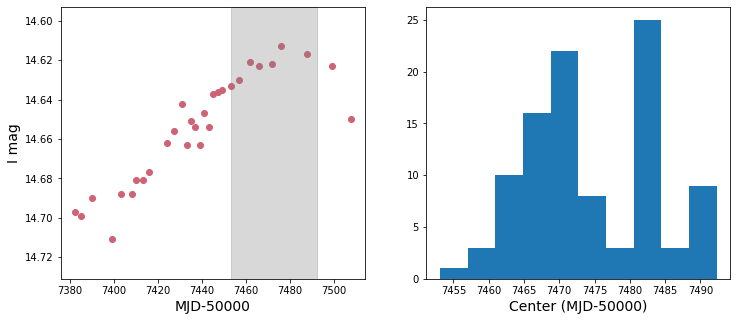

In [178]:
#check 8
bsp = f.bstri(sog4,flareinds,8,num=100)
f.plbs(sog4,flareinds,bsp,8) #bootstrapping tricky with this flare

In [179]:
bsp = f.bstri(sog4,flareinds,11,num=100)
bp_list.append(bsp)
bsp = f.bstri(sog4,flareinds,12,num=100)
bp_list.append(bsp)

In [180]:
np.max(bp_list[8])-np.min(bp_list[8])

36.12269688230754

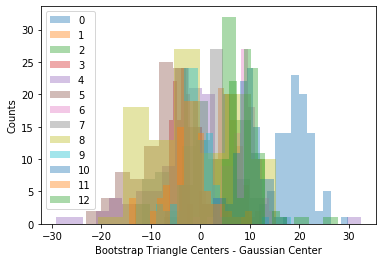

In [181]:
#sometimes flare 8 can go awry
for s in range(13):
    sb.distplot(bp_list[s]-gcenters[s],kde=False,label=str(s))
#plt.legend()
plt.xlabel('Bootstrap Triangle Centers - Gaussian Center')
plt.ylabel('Counts')
plt.legend()
png('bs_ghist')

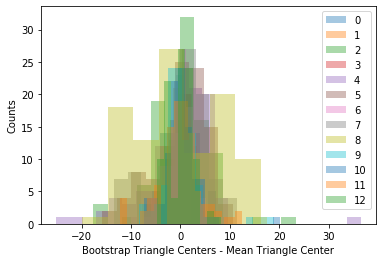

In [182]:
#repeat but wrt bootstrap triangle mean
for s in range(13):
    sb.distplot(bp_list[s]-np.mean(bp_list[s]),kde=False,label=str(s))
#plt.legend()
plt.xlabel('Bootstrap Triangle Centers - Mean Triangle Center')
plt.ylabel('Counts')
plt.legend()
png('bs_thist')

> this histogram is busy since it has 13 different overlapping colors (one per flare); but it both shows the width of the bootstrap distributions and how some are systematically different from the gaussian centers. we can now plot similar results on the flares themselves, which will be easier to understand.

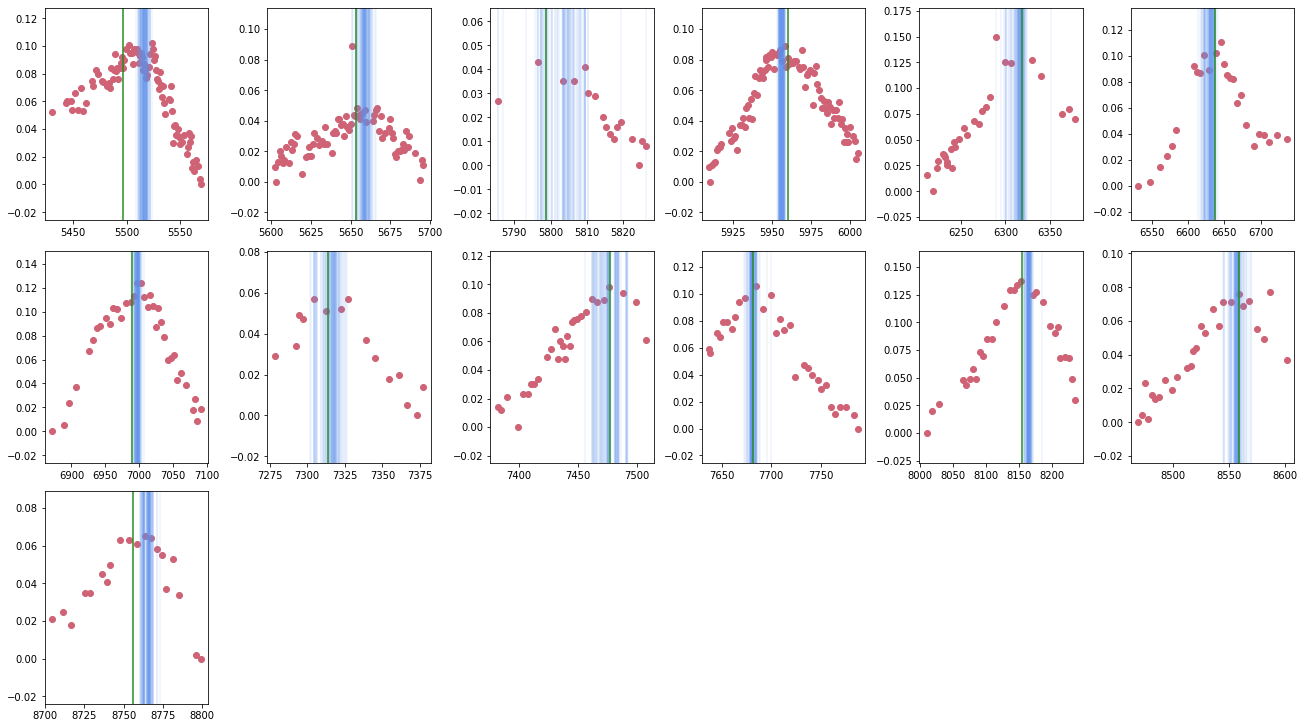

In [183]:
fig = plt.figure(constrained_layout=True,figsize=(18,10))
gs = fig.add_gridspec(3,6)
for i in range(13):
    if i < 6: axt = fig.add_subplot(gs[0, i])
    elif i < 12: axt = fig.add_subplot(gs[1, i-6])
    else: axt = fig.add_subplot(gs[2, i-12])
    st = flareinds[i][0]
    end = flareinds[i][1]
    stdate = int(sog4['MJD-50000'][st:st+1])
    enddate = int(sog4['MJD-50000'][end-1:end])
    axt.scatter(sog4['MJD-50000'][st:end],np.max(sog4['I mag'][st:end])-sog4['I mag'][st:end],color='#CF6275')
    for b in bp_list[i]:
            axt.axvline(b,alpha=.1,color='cornflowerblue')
    axt.axvline(gcenters[i],color='forestgreen')
png('bsg13flares')

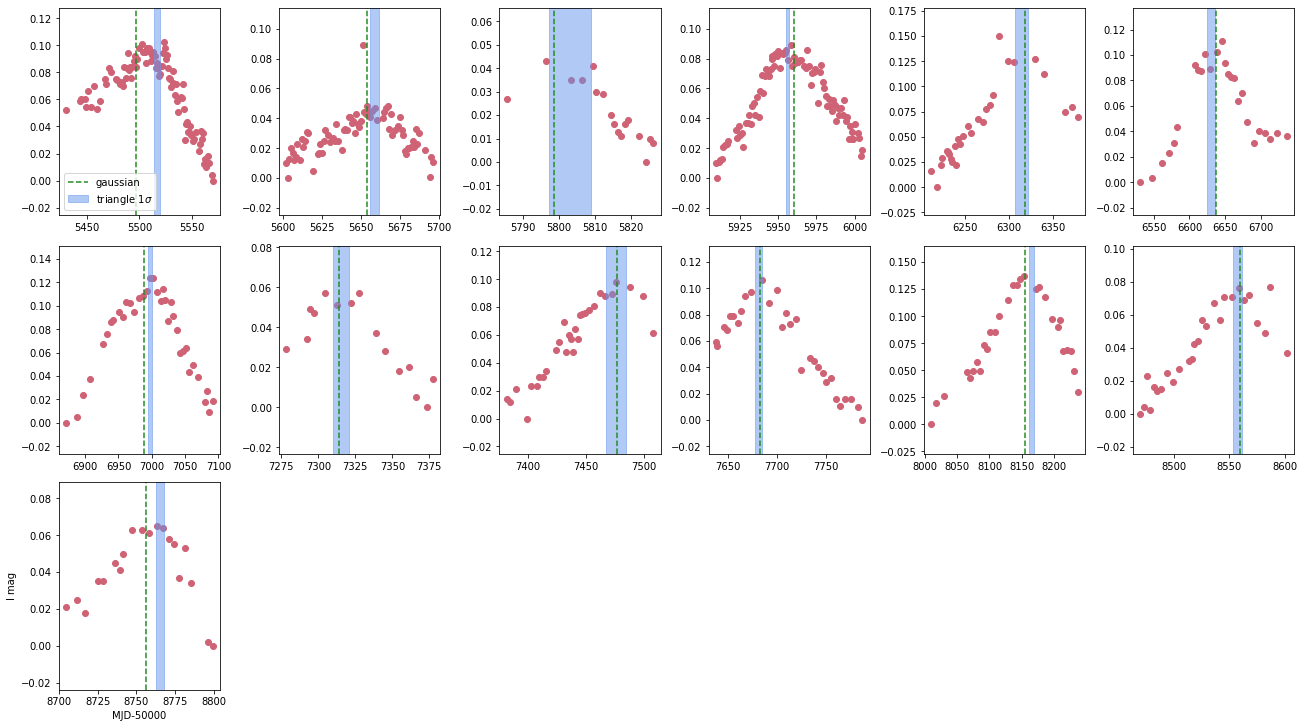

In [184]:
fig = plt.figure(constrained_layout=True,figsize=(18,10))
gs = fig.add_gridspec(3,6)
for i in range(13):
    if i < 6: axt = fig.add_subplot(gs[0, i])
    elif i < 12: axt = fig.add_subplot(gs[1, i-6])
    else: axt = fig.add_subplot(gs[2, i-12])
    st = flareinds[i][0]
    end = flareinds[i][1]
    stdate = int(sog4['MJD-50000'][st:st+1])
    enddate = int(sog4['MJD-50000'][end-1:end])
    axt.scatter(sog4['MJD-50000'][st:end],np.max(sog4['I mag'][st:end])-sog4['I mag'][st:end],color='#CF6275')

    axt.axvspan(np.mean(bp_list[i])-np.std(bp_list[i]),np.mean(bp_list[i])+np.std(bp_list[i]),color='cornflowerblue',alpha=.5,label='triangle 1$\sigma$')
    axt.axvline(gcenters[i],color='forestgreen',linestyle='dashed',label='gaussian')
    if i == 0: axt.legend()
plt.xlabel('MJD-50000')
plt.ylabel('I mag')
png('flarestdev')

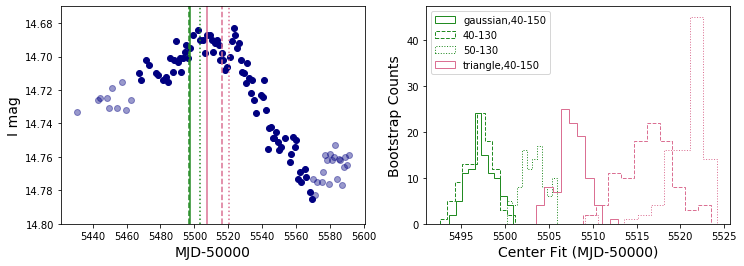

In [185]:
#gaussian and triangle of first flare
#on one plot; same color/linestyle scheme
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(sog4['MJD-50000'][50:130],sog4['I mag'][50:130],color='navy')
ax[0].scatter(sog4['MJD-50000'][40:50],sog4['I mag'][40:50],color='navy',alpha=.4)
ax[0].scatter(sog4['MJD-50000'][130:150],sog4['I mag'][130:150],color='navy',alpha=.4)
ax[0].axvline(np.mean(bsfits1['center']),label='gaussian,40-150',color='forestgreen')
ax[0].axvline(np.mean(bsfits2['center']),label='50-150',color='forestgreen',linestyle='dashed')
ax[0].axvline(np.mean(bsfits3['center']),label='40-130',color='forestgreen',linestyle='dotted')
ax[0].axvline(np.mean(bs1_150),label='triangle,40-150',color='palevioletred')
ax[0].axvline(np.mean(bs1_100),color='palevioletred',linestyle='dashed')
ax[0].axvline(np.mean(bs1_50),color='palevioletred',linestyle='dotted')

ax[1].hist(bsfits1['center'],histtype='step',label='gaussian,40-150',color='forestgreen')
ax[1].hist(bsfits2['center'],histtype='step',label='40-130',color='forestgreen',linestyle='dashed')
ax[1].hist(bsfits3['center'],histtype='step',label='50-130',color='forestgreen',linestyle='dotted')
ax[1].hist(bs1_150,histtype='step',label='triangle,40-150',color='palevioletred')
ax[1].hist(bs1_100,histtype='step',color='palevioletred',linestyle='dashed')
ax[1].hist(bs1_50,histtype='step',color='palevioletred',linestyle='dotted')
ax[1].legend()
ax[0].set_ylim(14.8,14.67)
ax[0].set_xlabel('MJD-50000',fontsize=14)
ax[1].set_xlabel('Center Fit (MJD-50000)',fontsize=14)
ax[0].set_ylabel('I mag',fontsize=14)
ax[1].set_ylabel('Bootstrap Counts',fontsize=14)
png('ffgt')

# 10. Comparing All Models
- most updated flare hist is above; can consider incorporating different index ranges; sine 

In [186]:
#need result rather than best values from gauss+line
reload(f)
glres = []
for i in range(13):
    #prints each center result
    flfit = f.gaussline(sog4,flareinds,i,gout,more=True,plot=False) #can set to True to print out each flare fit
    glres.append(flfit)

In [187]:
glres[0].redchi

5.7875203603154875e-05

In [188]:
gout[0].redchi

0.00012026354364757216

In [189]:
#simple triangle model; no changes
reload(f)
tpks = [] #triangle peaks
tfits = [] #triangle fits
newxs = []
for i in range(13):
    if i == 2:
    #changes based on div; doesn't work with div=0
        pk,nx,tfit = f.triangfit(sog4,flareinds,i,div=3,plot=False,params=True)
    else: 
        pk,nx,tfit = f.triangfit(sog4,flareinds,i,plot=False,params=True)
    tpks.append(pk)
    tfits.append(tfit)
    newxs.append(nx)

[-5.35256696e-04  1.78098491e+01  1.66490008e-03  5.03982789e+00]
5804.141487937649


[-5.35256696e-04  1.78098491e+01  1.66490008e-03  5.03982789e+00]
5804.141487937649


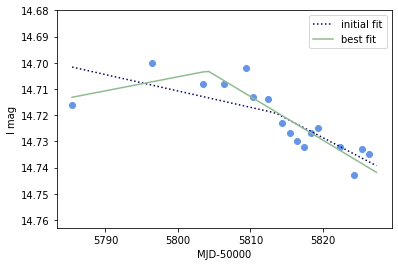

In [190]:
#try to fit third flare
pk,nx,tfit = f.triangfit(sog4,flareinds,2,div=3,plot=True,params=True)


In [191]:
from lmfit import Model


Text(0, 0.5, 'I mag')

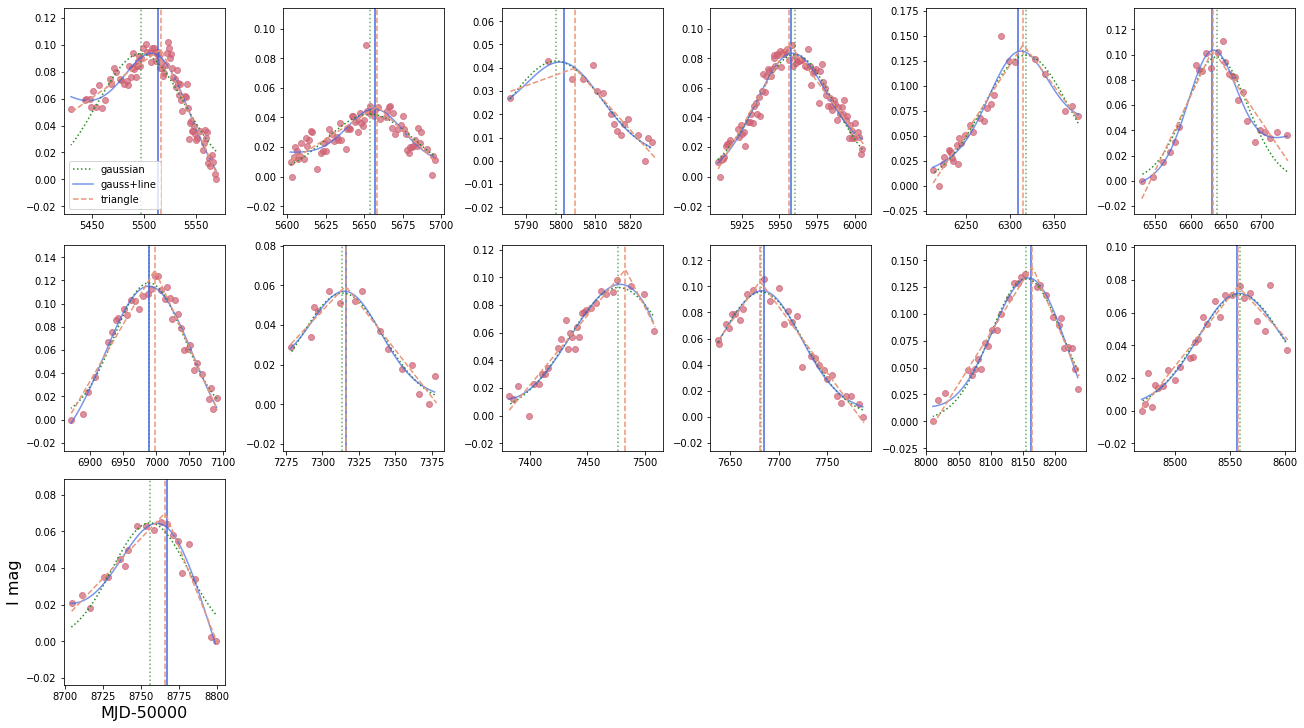

In [192]:
#plot the actual models and their centers
fig = plt.figure(constrained_layout=True,figsize=(18,10))
gs = fig.add_gridspec(3,6)
mod2 = Model(f.gaussian) + Model(f.line)
for i in range(13):
    if i < 6: axt = fig.add_subplot(gs[0, i])
    elif i < 12: axt = fig.add_subplot(gs[1, i-6])
    else: axt = fig.add_subplot(gs[2, i-12])
    st = flareinds[i][0]
    end = flareinds[i][1]
    stdate = int(sog4['MJD-50000'][st:st+1])
    enddate = int(sog4['MJD-50000'][end-1:end])
    axt.scatter(sog4['MJD-50000'][st:end],np.max(sog4['I mag'][st:end])-sog4['I mag'][st:end],color='#CF6275',alpha=.7)
    axt.axvline(gcenters[i],color='forestgreen',linestyle='dotted',alpha=.7)
#     axt.axvline(off6_centers[i],color='rebeccapurple',linestyle='dashed')
    axt.axvline(glcenters[i],color='royalblue')
    axt.axvline(tpks[i],color='darksalmon',linestyle='dashed')
    #plot models
    #simple gaussian
    xfits = np.linspace(enddate,stdate,enddate-stdate)
    gfit = f.gaussian(xfits,gout[i].best_values['amplitude'],gout[i].best_values['center'],gout[i].best_values['sigma'])
    axt.plot(xfits,gfit,color='forestgreen',label='gaussian',linestyle='dotted') 
    #offset .06 mags,but shift down
#     goffit = -.06+f.gaussian(xfits,goff_outs[3][i].best_values['amplitude'],goff_outs[3][i].best_values['center'],goff_outs[3][i].best_values['sigma'])
#     axt.plot(xfits,goffit,color='rebeccapurple',linestyle='dashed',label='gauss,offset .06')
    #gauss+line
    #create function with more x values if observations spaced by more than a day
    if len(sog4['MJD-50000'][st:end]) < (enddate-stdate):
        result = glres[i]
        #create new model with same parameters and plot initial fit
        pars2 = mod2.make_params(amp=result.params['amp'].value,cen=result.params['cen'].value,wid=result.params['wid'].value,
                      slope=result.params['slope'].value,intercept=result.params['intercept'].value)
        x2 = np.linspace(stdate,enddate)
        #interpolate y values to get more y values; may not be needed since not using best fit anyway
        y2 = np.interp(x2,sog4['MJD-50000'][st:end],sog4['I mag'][st:end])
        result2 = mod2.fit(y2,pars2,x=x2)
        axt.plot(x2,result2.init_fit,color='royalblue',linestyle='solid',label='gauss+line',alpha=.7)  
    else: axt.plot(sog4['MJD-50000'][st:end],glres[i].best_fit,color='royalblue',linestyle='solid',label='gauss+line',alpha=.7)  
    #simple triangle model; no changes to indices or bootstrapping
    #have to shift triangle
    axt.plot(newxs[i],np.max(sog4['I mag'][st:end])-tfits[i],color='darksalmon',linestyle='dashed',label='triangle')  
    if i == 0: axt.legend()
plt.xlabel('MJD-50000',fontsize=16)
plt.ylabel('I mag',fontsize=16)
#png('3modflares')

In [193]:
tpks-gcenters

array([19.43854423,  4.87664425,  5.54893902, -3.90036437, -3.25971911,
       -6.10309082,  8.76073257,  2.11950849,  6.07980889, -1.29033705,
        9.19769996, -2.17850355, 10.06790381])

## try using np.savez to save some variables

In [194]:
#save hist cens 
np.savez('hist_gcens',hist_gcens)

In [195]:
np.savez('hist_gtcens',hist_gtcens)

## some extra, quick analysis


In [196]:
#compare reduced chi squared of gaussian and gaussian+line
for g in range(13):
    print(glres[g].redchi - gout[g].redchi)

-6.238834004441729e-05
-7.210401988038865e-06
3.4104807820292427e-06
-3.5766528715936276e-06
-3.878887616208065e-06
-9.351869244602029e-05
-1.0796780161702869e-05
4.54951459720375e-06
-1.597309338047675e-06
3.318479818128444e-06
-1.0580613306324621e-05
4.8975902794668095e-06
-4.6706513945723744e-05


In [197]:
#compare redchi of gaussian+line and triangle
trchis = []
for i in range(13):
    if i == 2:
    #changes based on div; doesn't work with div=0
        pk,chi,rchi = f.triangfit(sog4,flareinds,i,div=3,plot=False,chis=True)
    else: 
        pk,chi,rchi = f.triangfit(sog4,flareinds,i,plot=False,chis=True)
    trchis.append(rchi)


[-5.35256696e-04  1.78098491e+01  1.66490008e-03  5.03982789e+00]
5804.141487937649


In [198]:
for g in range(13):
    print(glres[g].redchi - trchis[g])

-3.667774688041537e-06
2.7049500895621114e-07
-6.658367810018262e-06
-2.722844677471582e-06
-1.7542781281775334e-05
-8.713603043244473e-05
-1.6969928272746437e-05
-1.063401729941317e-05
-9.237979301303576e-06
-2.165146858974936e-06
-3.1883663923794034e-05
-1.4123531762325281e-06
-8.720231114045475e-06


## try to make smooth gaussian+line

In [199]:
from lmfit.models import GaussianModel
from numpy import exp, pi, sqrt
from lmfit import Model

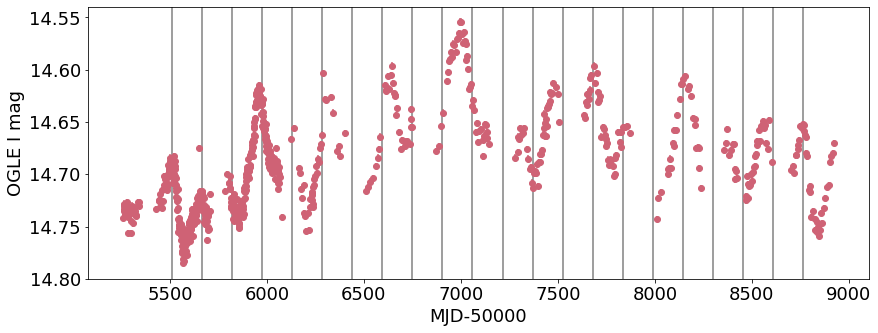

In [200]:
plt.figure(figsize=(14,5))
plt.errorbar(sog4['MJD-50000'],sog4['I mag'],yerr=sog4['I mag err'],linestyle='none',marker='o',color='#CF6275')
plt.ylim(14.8,14.54)
plt.tick_params(labelsize=18)
plt.xlabel('MJD-50000',fontsize=18)
plt.ylabel('OGLE I mag',fontsize=18)
for i in range(22):
    plt.axvline(5510+155*i,color='grey')
#plt.savefig('presIlc.png',dpi=200,bbox_inches='tight',transparent=True)

In [201]:
gcenters

array([5497.02562862, 5653.72166481, 5798.59254892, 5960.25093808,
       6318.46915905, 6637.29443862, 6988.8826026 , 7313.79524415,
       7476.98189219, 7682.03539062, 8155.10721353, 8559.43375779,
       8755.94374512])

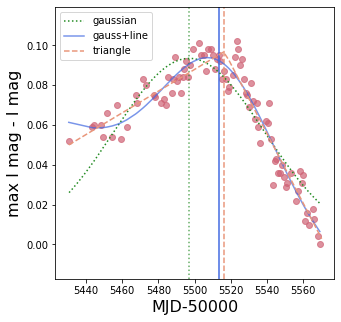

In [202]:
#modeling plot of just first flare
plt.figure(figsize=(5,5))
st = flareinds[0][0]
end = flareinds[0][1]
stdate = int(sog4['MJD-50000'][st:st+1])
enddate = int(sog4['MJD-50000'][end-1:end])
plt.scatter(sog4['MJD-50000'][st:end],np.max(sog4['I mag'][st:end])-sog4['I mag'][st:end],color='#CF6275',alpha=.7)
plt.axvline(gcenters[0],color='forestgreen',linestyle='dotted',alpha=.7)
#axt.axvline(off6_centers[i],color='rebeccapurple',linestyle='dashed')
plt.axvline(glcenters[0],color='royalblue')
plt.axvline(tpks[0],color='darksalmon',linestyle='dashed')
    #plot models
    #simple gaussian
xfits = np.linspace(enddate,stdate,enddate-stdate)
gfit = f.gaussian(xfits,gout[0].best_values['amplitude'],gout[0].best_values['center'],gout[0].best_values['sigma'])
plt.plot(xfits,gfit,color='forestgreen',label='gaussian',linestyle='dotted') 
plt.plot(sog4['MJD-50000'][st:end],glres[0].best_fit,color='royalblue',linestyle='solid',label='gauss+line',alpha=.7)  
#simple triangle model; no changes to indices or bootstrapping
#have to shift triangle
plt.plot(newxs[0],np.max(sog4['I mag'][st:end])-tfits[0],color='darksalmon',linestyle='dashed',label='triangle')  
plt.legend()
plt.xlabel('MJD-50000',fontsize=16)
plt.ylabel('max I mag - I mag',fontsize=16)
png('presflare')

# Bootstrap Gaussian + Line
- can then make one hist per flare with three different bootstrap results

In [203]:
import flare as f

In [204]:
reload(f)
bs_gl1 = f.bootgl(sog4,flareinds,0,gout)

In [205]:
bs_gl1['center'].describe()

count     100.000000
mean     5513.644966
std         1.197670
min      5510.280051
25%      5512.887296
50%      5513.567409
75%      5514.443079
max      5516.323504
Name: center, dtype: float64

In [206]:
bs_gl2 = f.bootgl(sog4,flareinds,1,gout)

In [207]:
bs_gl2['center'].describe()

count     100.000000
mean     5658.064499
std         4.017262
min      5651.602753
25%      5656.113102
50%      5657.427997
75%      5658.826415
max      5683.721611
Name: center, dtype: float64

In [208]:
#start list of centers
bs_glcenters = [np.array(bs_gl1['center']),np.array(bs_gl2['center'])]

In [209]:
bs_gl3 = f.bootgl(sog4,flareinds,2,gout)

In [210]:
bs_gl3['center'].describe()

count     100.000000
mean     5786.725075
std        16.022038
min      5768.592549
25%      5774.398128
50%      5775.146354
75%      5801.216490
max      5828.592549
Name: center, dtype: float64

In [211]:
bs_glcenters.append(np.array(bs_gl3['center']))

In [212]:
bs_gl4 = f.bootgl(sog4,flareinds,3,gout)
bs_glcenters.append(np.array(bs_gl4['center']))

In [213]:
bs_gl5 = f.bootgl(sog4,flareinds,4,gout)
bs_glcenters.append(np.array(bs_gl5['center']))
bs_gl6 = f.bootgl(sog4,flareinds,5,gout)
bs_glcenters.append(np.array(bs_gl6['center']))
bs_gl7 = f.bootgl(sog4,flareinds,6,gout)
bs_glcenters.append(np.array(bs_gl7['center']))

In [214]:
bs_gl8 = f.bootgl(sog4,flareinds,7,gout)
bs_glcenters.append(np.array(bs_gl8['center']))
bs_gl9 = f.bootgl(sog4,flareinds,8,gout)
bs_glcenters.append(np.array(bs_gl9['center']))
bs_gl10 = f.bootgl(sog4,flareinds,9,gout)
bs_glcenters.append(np.array(bs_gl10['center']))

In [215]:
bs_gl11 = f.bootgl(sog4,flareinds,10,gout)
bs_glcenters.append(np.array(bs_gl11['center']))
bs_gl12 = f.bootgl(sog4,flareinds,11,gout)
bs_glcenters.append(np.array(bs_gl12['center']))
bs_gl13 = f.bootgl(sog4,flareinds,12,gout)
bs_glcenters.append(np.array(bs_gl13['center']))

In [216]:
glcenters[1]

5657.1927609449285

In [217]:
#taking out obvious outliers; g+line particularly sensitive
count = 0
for i in range(13):
    for j in range(100):
        if np.abs(bs_glcenters[i][j] - glcenters[i]) > 15: #allows difference of 15 days in each direction from g+line with all points
            bs_glcenters[i][j] = np.nan
            count +=1
count

160

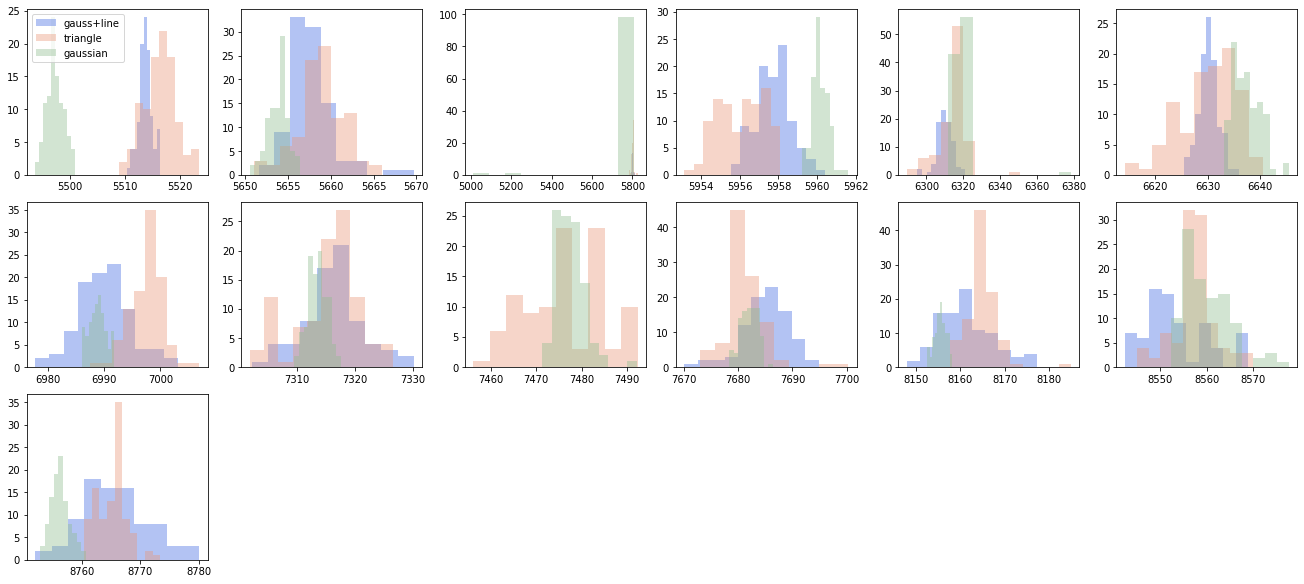

In [218]:
#took out g+line bootstrap results more than 30 days from original g+line centers
fig = plt.figure(constrained_layout=True,figsize=(18,8))
gs = fig.add_gridspec(3,6)
    
for i in range(13):
    if i < 6: axt = fig.add_subplot(gs[0, i])
    #second row of plots
    elif i < 12: axt = fig.add_subplot(gs[1, i-6])
    #final flare in third row
    else: axt = fig.add_subplot(gs[2, i-12])
    if i != 8: axt.hist(bs_glcenters[i],label='gauss+line',color='royalblue',alpha=.4)
    axt.hist(bp_list[i],label='triangle',color='darksalmon',alpha=.4,linestyle='dashed')
    if i > 0: axt.hist(gbs[i-1]['center'],color='darkseagreen',alpha=.4,linestyle='dotted')
    else: axt.hist(bsfits1['center'],label='gaussian',color='darkseagreen',alpha=.4,linestyle='dotted')
    if i == 0: plt.legend()

In [219]:
#filter bootstrap results that are obviously wrong
gbs[1]['center'] = gbs[1]['center'][np.abs(gbs[1]['center']-gcenters[2])<30]

In [220]:
np.nanmedian(gbs[1]['center'])-np.nanstd(gbs[1]['center'])

5794.849489341677

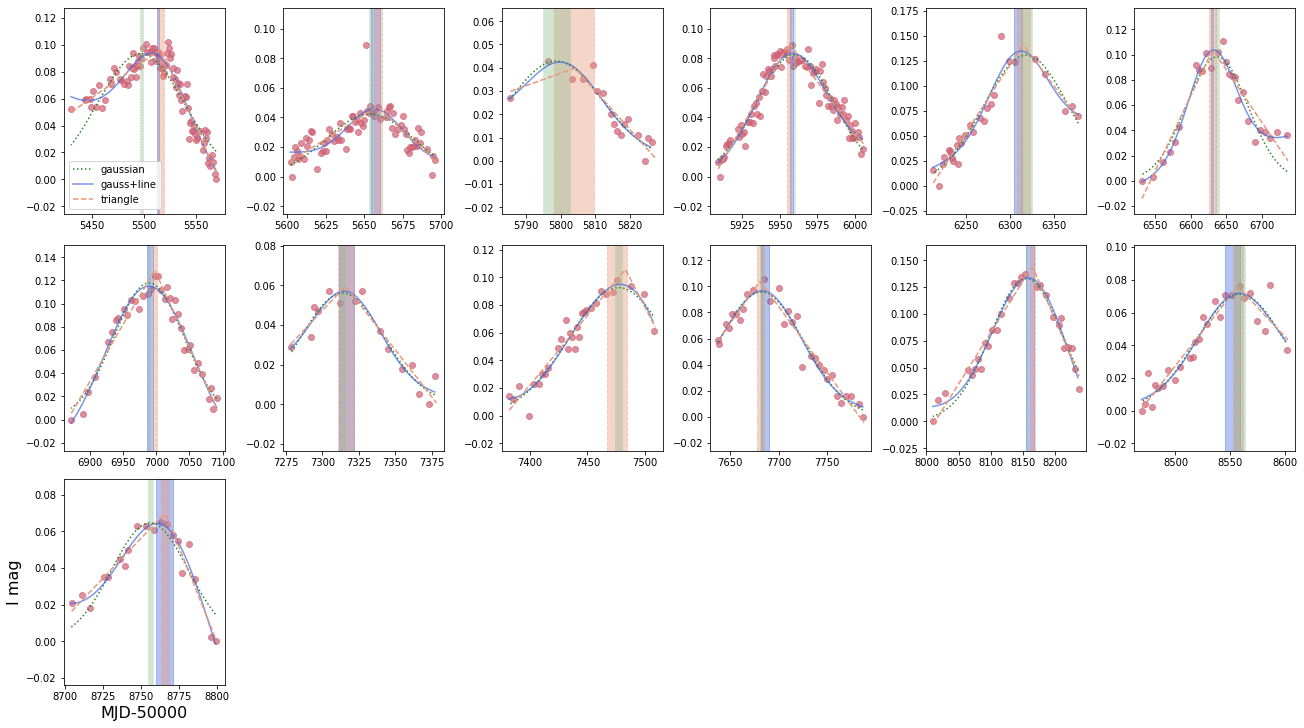

In [221]:
#13 flares with one sigma in each direction from each bootstrapping method
fig = plt.figure(constrained_layout=True,figsize=(18,10))
gs = fig.add_gridspec(3,6)
mod2 = Model(f.gaussian) + Model(f.line)
for i in range(13):
    if i < 6: axt = fig.add_subplot(gs[0, i])
    elif i < 12: axt = fig.add_subplot(gs[1, i-6])
    else: axt = fig.add_subplot(gs[2, i-12])
    st = flareinds[i][0]
    end = flareinds[i][1]
    stdate = int(sog4['MJD-50000'][st:st+1])
    enddate = int(sog4['MJD-50000'][end-1:end])
    axt.scatter(sog4['MJD-50000'][st:end],np.max(sog4['I mag'][st:end])-sog4['I mag'][st:end],color='#CF6275',alpha=.7)
    #add shading for one sigma from bootstrapping
    #gauss+line
    if i != 8 and i != 2: axt.axvspan(np.nanmedian(bs_glcenters[i])-np.nanstd(bs_glcenters[i]),np.nanmedian(bs_glcenters[i])+np.nanstd(bs_glcenters[i]),color='royalblue',alpha=.4)
    #triangle
    axt.axvspan(np.nanmedian(bp_list[i])-np.nanstd(bp_list[i]),np.nanmedian(bp_list[i])+np.nanstd(bp_list[i]),color='darksalmon',alpha=.4,linestyle='dashed')
    #gaussian
    if i > 0: axt.axvspan(np.nanmedian(gbs[i-1]['center'])-np.nanstd(gbs[i-1]['center']),np.nanmedian(gbs[i-1]['center'])+np.nanstd(gbs[i-1]['center']),color='darkseagreen',alpha=.4,linestyle='dotted')
    else: axt.axvspan(np.nanmedian(bsfits1['center'])-np.nanstd(bsfits1['center']),np.nanmedian(bsfits1['center'])+np.nanstd(bsfits1['center']),color='darkseagreen',alpha=.4,linestyle='dotted')
    
    #plot models
    #simple gaussian
    xfits = np.linspace(enddate,stdate,enddate-stdate)
    gfit = f.gaussian(xfits,gout[i].best_values['amplitude'],gout[i].best_values['center'],gout[i].best_values['sigma'])
    axt.plot(xfits,gfit,color='forestgreen',label='gaussian',linestyle='dotted') 
    #offset .06 mags,but shift down
#     goffit = -.06+f.gaussian(xfits,goff_outs[3][i].best_values['amplitude'],goff_outs[3][i].best_values['center'],goff_outs[3][i].best_values['sigma'])
#     axt.plot(xfits,goffit,color='rebeccapurple',linestyle='dashed',label='gauss,offset .06')
    #gauss+line
    #create function with more x values if observations spaced by more than a day
    if len(sog4['MJD-50000'][st:end]) < (enddate-stdate):
        result = glres[i]
        #create new model with same parameters and plot initial fit
        pars2 = mod2.make_params(amp=result.params['amp'].value,cen=result.params['cen'].value,wid=result.params['wid'].value,
                      slope=result.params['slope'].value,intercept=result.params['intercept'].value)
        x2 = np.linspace(stdate,enddate)
        #interpolate y values to get more y values; may not be needed since not using best fit anyway
        y2 = np.interp(x2,sog4['MJD-50000'][st:end],sog4['I mag'][st:end])
        result2 = mod2.fit(y2,pars2,x=x2)
        axt.plot(x2,result2.init_fit,color='royalblue',linestyle='solid',label='gauss+line',alpha=.7)  
    else: axt.plot(sog4['MJD-50000'][st:end],glres[i].best_fit,color='royalblue',linestyle='solid',label='gauss+line',alpha=.7)  
    #simple triangle model; no changes to indices or bootstrapping
    #have to shift triangle
    axt.plot(newxs[i],np.max(sog4['I mag'][st:end])-tfits[i],color='darksalmon',linestyle='dashed',label='triangle')  
    if i == 0: axt.legend()
plt.xlabel('MJD-50000',fontsize=16)
plt.ylabel('I mag',fontsize=16)
png('3bsflares')

Text(0, 0.5, 'I mag')

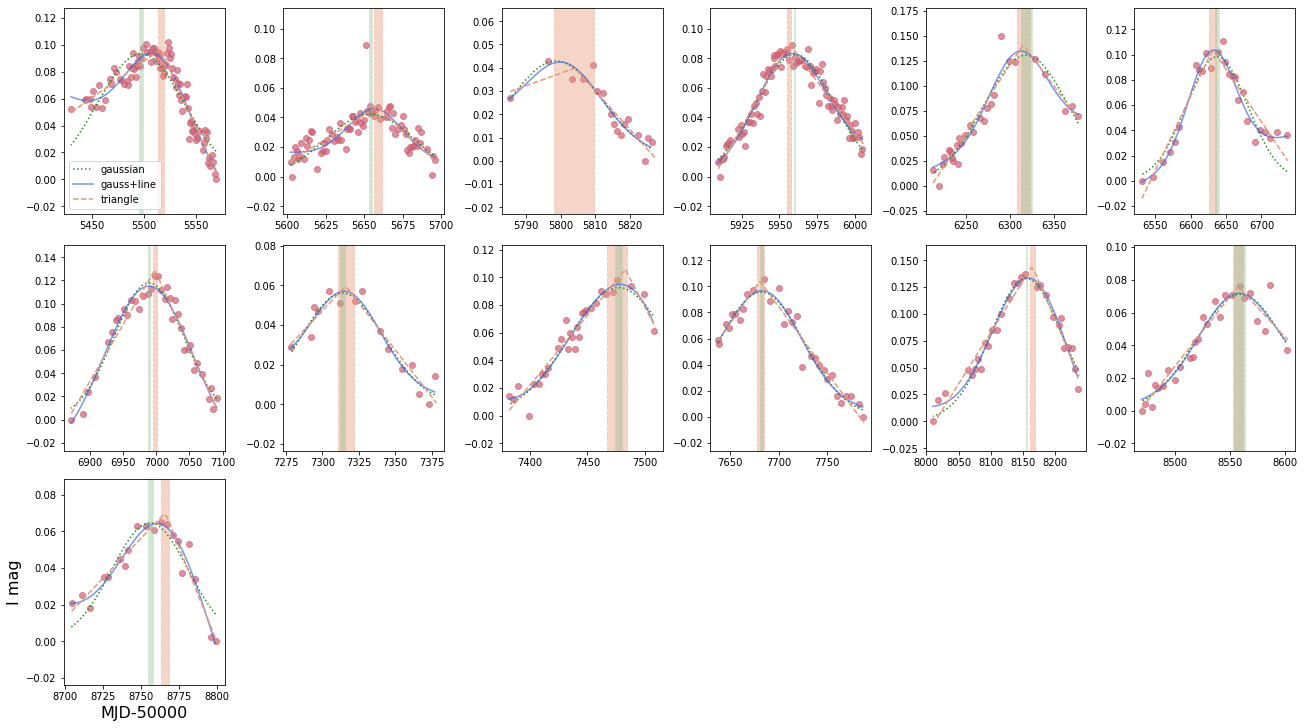

In [222]:
#repeating without gaussian+line bootstrap
fig = plt.figure(constrained_layout=True,figsize=(18,10))
gs = fig.add_gridspec(3,6)
mod2 = Model(f.gaussian) + Model(f.line)
for i in range(13):
    if i < 6: axt = fig.add_subplot(gs[0, i])
    elif i < 12: axt = fig.add_subplot(gs[1, i-6])
    else: axt = fig.add_subplot(gs[2, i-12])
    st = flareinds[i][0]
    end = flareinds[i][1]
    stdate = int(sog4['MJD-50000'][st:st+1])
    enddate = int(sog4['MJD-50000'][end-1:end])
    axt.scatter(sog4['MJD-50000'][st:end],np.max(sog4['I mag'][st:end])-sog4['I mag'][st:end],color='#CF6275',alpha=.7)
    #add shading for one sigma from bootstrapping
    axt.axvspan(np.median(bp_list[i])-np.std(bp_list[i]),np.median(bp_list[i])+np.std(bp_list[i]),color='darksalmon',alpha=.4,linestyle='dashed')
    if i > 0: axt.axvspan(np.median(gbs[i-1]['center'])-np.std(gbs[i-1]['center']),np.median(gbs[i-1]['center'])+np.std(gbs[i-1]['center']),color='darkseagreen',alpha=.4,linestyle='dotted')
    else: axt.axvspan(np.median(bsfits1['center'])-np.std(bsfits1['center']),np.median(bsfits1['center'])+np.std(bsfits1['center']),color='darkseagreen',alpha=.4,linestyle='dotted')
    
    
    
    #plot models
    #simple gaussian
    xfits = np.linspace(enddate,stdate,enddate-stdate)
    gfit = f.gaussian(xfits,gout[i].best_values['amplitude'],gout[i].best_values['center'],gout[i].best_values['sigma'])
    axt.plot(xfits,gfit,color='forestgreen',label='gaussian',linestyle='dotted') 
    #offset .06 mags,but shift down
#     goffit = -.06+f.gaussian(xfits,goff_outs[3][i].best_values['amplitude'],goff_outs[3][i].best_values['center'],goff_outs[3][i].best_values['sigma'])
#     axt.plot(xfits,goffit,color='rebeccapurple',linestyle='dashed',label='gauss,offset .06')
    #gauss+line
    #create function with more x values if observations spaced by more than a day
    if len(sog4['MJD-50000'][st:end]) < (enddate-stdate):
        result = glres[i]
        #create new model with same parameters and plot initial fit
        pars2 = mod2.make_params(amp=result.params['amp'].value,cen=result.params['cen'].value,wid=result.params['wid'].value,
                      slope=result.params['slope'].value,intercept=result.params['intercept'].value)
        x2 = np.linspace(stdate,enddate)
        #interpolate y values to get more y values; may not be needed since not using best fit anyway
        y2 = np.interp(x2,sog4['MJD-50000'][st:end],sog4['I mag'][st:end])
        result2 = mod2.fit(y2,pars2,x=x2)
        axt.plot(x2,result2.init_fit,color='royalblue',linestyle='solid',label='gauss+line',alpha=.7)  
    else: axt.plot(sog4['MJD-50000'][st:end],glres[i].best_fit,color='royalblue',linestyle='solid',label='gauss+line',alpha=.7)  
    #simple triangle model; no changes to indices or bootstrapping
    #have to shift triangle
    axt.plot(newxs[i],np.max(sog4['I mag'][st:end])-tfits[i],color='darksalmon',linestyle='dashed',label='triangle')  
    if i == 0: axt.legend()
plt.xlabel('MJD-50000',fontsize=16)
plt.ylabel('I mag',fontsize=16)

# Compile DataFrame for Final Values and Errors

In [223]:
#replace with DataFrame
flerr = pd.DataFrame(columns=['gaussian center','med gaussian boot','gaussian stdev',
                              'g+line center','med g+line boot','g+line stdev',
                              'triangle center','med triangle boot','triangle stdev'])
flerr['gaussian center'] = gcenters
flerr['g+line center'] = glcenters
flerr['triangle center'] = tpks

In [224]:
for i in range(13):
    flerr['med triangle boot'][i] = np.nanmedian(bp_list[i])
    flerr['triangle stdev'][i] = np.nanstd(bp_list[i])
    flerr['med g+line boot'][i] = np.nanmedian(bs_glcenters[i])
    flerr['g+line stdev'][i] = np.nanstd(bs_glcenters[i])
    if i == 0:
        flerr['med gaussian boot'][i] = np.nanmedian(bsfits1['center'])
        flerr['gaussian stdev'][i] = np.nanstd(bsfits1['center'])
    else:
        flerr['med gaussian boot'][i] = np.nanmedian(gbs[i-1]['center'])
        flerr['gaussian stdev'][i] = np.nanstd(gbs[i-1]['center'])

In [225]:
#adding simple differences between centers
flerr['tri-gauss'] = flerr['triangle center'] - flerr['gaussian center']  
flerr['tri-g+line'] = flerr['triangle center'] - flerr['g+line center']

In [226]:
flerr

,gaussian center,med gaussian boot,gaussian stdev,g+line center,med g+line boot,g+line stdev,triangle center,med triangle boot,triangle stdev,tri-gauss,tri-g+line
0,5497.025629,5497.2,1.55776,5513.343428,5513.57,1.19167,5516.464173,5516.49,2.92832,19.438544,3.120745
1,5653.721665,5654.02,1.13032,5657.192761,5657.32,2.61838,5658.598309,5658.9,2.79163,4.876644,1.405548
2,5798.592549,5798.81,3.95833,5800.959890,5801.41,4.43117,5804.141488,5803.81,5.80082,5.548939,3.181598
3,5960.250938,5960.11,0.430399,5957.653691,5957.8,0.923187,5956.350574,5956.22,1.18446,-3.900364,-1.303117
4,6318.469159,6319.01,6.33337,6309.559311,6309.47,4.42053,6315.209440,6315.59,7.38252,-3.259719,5.650128
5,6637.294439,6637.18,2.54899,6630.221666,6629.99,1.81233,6631.191348,6630.78,5.41975,-6.103091,0.969681
6,6988.882603,6988.8,1.46966,6988.826699,6990.41,4.52436,6997.643335,6997.9,2.92108,8.760733,8.816636
7,7313.795244,7313.65,1.60283,7316.457984,7316.59,5.16328,7315.914753,7316.45,5.57513,2.119508,-0.543231
8,7476.981892,7477.22,3.1014,NaN,7447.3,28.8044,7483.061701,7475.88,8.58564,6.079809,NaN
9,7682.035391,7682.11,1.53815,7685.004597,7685.53,4.23855,7680.745054,7680.91,3.66955,-1.290337,-4.259544


### specific flare tests -- can delete when done

In [227]:
f.oneflareg(sog4,[130,160],[235,240],gline=True)

array([[5663.62452   , 5650.07069084],
       [5657.19203984, 5655.69449626]])

In [228]:
bp_arr = np.array(bp_list)
bp_arr[1][bp_arr[1]>5660]

array([5660.61249056, 5661.46473322, 5661.13499069, 5660.72945408,
       5661.51811255, 5661.7707447 , 5660.48336   , 5663.01687573,
       5666.01708195, 5665.39458336, 5662.26483765, 5661.79263359,
       5662.88832851, 5660.1985471 , 5661.6019065 , 5660.27101001,
       5661.67729849, 5661.71224264, 5664.09522641, 5663.50290434,
       5662.04799167, 5660.18024473, 5663.27004345, 5662.61489147,
       5661.7353671 , 5660.26038733, 5661.66520939, 5662.3227374 ,
       5660.94376468, 5660.99076482])

In [229]:
bs_glcenters[1]

array([5657.69735899, 5654.07438262, 5657.58404815, 5656.99651568,
       5658.22218579, 5653.69638305, 5659.45302235, 5656.04728778,
       5653.24641569, 5657.41419963, 5659.69665817, 5662.27427223,
       5658.07966038, 5663.3668473 , 5656.17408332, 5658.57046352,
       5659.99106655, 5657.70388405, 5655.38321466, 5658.06792988,
       5656.9517401 , 5653.65331963, 5655.73052138, 5656.19045458,
       5656.27809028, 5659.55683475, 5651.60275332, 5655.22967187,
       5666.11536108, 5669.72258735, 5655.61597111, 5656.78112779,
       5654.31264748, 5658.79762801, 5660.56279614, 5654.23903565,
       5662.56798174, 5657.44558199, 5656.60455033, 5655.37941583,
       5656.98396607, 5658.39824734, 5656.44767485, 5655.19041051,
       5660.54064649, 5658.19656411, 5656.52217107, 5659.19691469,
       5658.11831866, 5658.66959395,           nan, 5657.09777154,
       5657.85029651, 5655.75876059, 5657.66138207, 5657.58478179,
       5655.67162672, 5656.76052188, 5659.22774559, 5656.03412

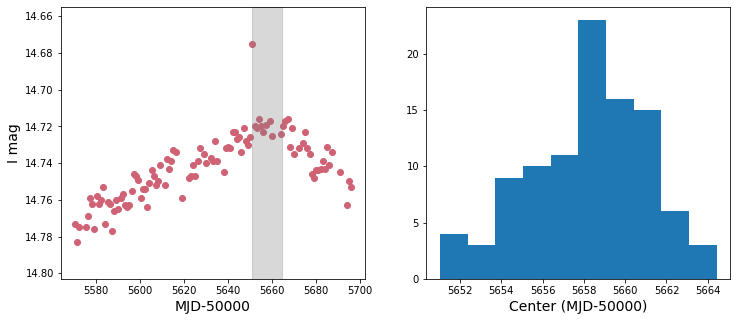

In [230]:
#test triangle w more points
testbs2 = f.bstri(sog4,flareinds,1,indiv=True,si=130,ei=235,num=100)
f.plbs(sog4,flareinds,testbs2,1,indiv=True,si=130,ei=235)

In [231]:
np.quantile(testbs2,1) #5662 w/ last five points

5664.426924789774

In [232]:
np.mean(testbs2) 

5658.267723148139

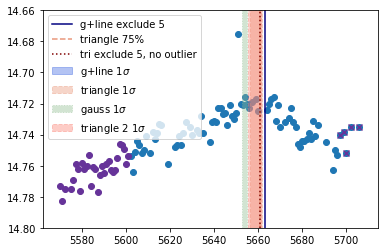

In [233]:
plt.scatter(sog4['MJD-50000'][160:240],sog4['I mag'][160:240]) #flareinds; current fits
plt.scatter(sog4['MJD-50000'][130:160],sog4['I mag'][130:160],color='rebeccapurple') #flareinds; current fits
plt.scatter(sog4['MJD-50000'][235:240],sog4['I mag'][235:240],color='rebeccapurple',marker='x') #flareinds; current fits
plt.axvline(5663,color='navy',label='g+line exclude 5')
plt.axvspan(np.median(bs_glcenters[1])-np.std(bs_glcenters[1]),np.median(bs_glcenters[1])+np.std(bs_glcenters[1]),color='royalblue',alpha=.4,label='g+line 1$\sigma$')
plt.axvspan(np.median(bp_list[1])-np.std(bp_list[1]),np.median(bp_list[1])+np.std(bp_list[1]),color='darksalmon',label='triangle 1$\sigma$',alpha=.4,linestyle='dashed')
plt.axvspan(np.median(gbs[0]['center'])-np.std(gbs[0]['center']),np.median(gbs[0]['center'])+np.std(gbs[0]['center']),label='gauss 1$\sigma$',color='darkseagreen',alpha=.4,linestyle='dotted')
plt.axvline(5661,label='triangle 75%',color='darksalmon',linestyle='dashed')
plt.axvline(5661,label='tri exclude 5, no outlier',color='maroon',linestyle='dotted')
plt.axvspan(np.median(testbs2)-np.std(testbs2),np.median(testbs2)+np.std(testbs2),color='salmon',label='triangle 2 1$\sigma$',alpha=.4,linestyle='dashed')

plt.ylim(14.8,14.66)
plt.legend()
#png('secondq')

In [234]:
np.quantile(bp_arr[1],1)

5666.017081949097

> is this effect just because of the outlier?
- gaussian center doesn't change
- triangle?

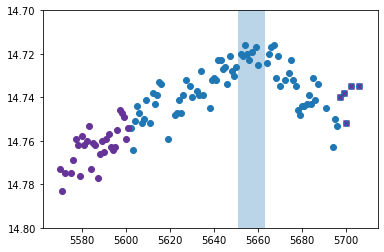

In [235]:
plt.scatter(sog4['MJD-50000'][160:240],sog4['I mag'][160:240]) #flareinds; current fits
plt.scatter(sog4['MJD-50000'][130:160],sog4['I mag'][130:160],color='rebeccapurple') #flareinds; current fits
plt.scatter(sog4['MJD-50000'][235:240],sog4['I mag'][235:240],color='rebeccapurple',marker='x')
plt.ylim(14.8,14.7)
plt.axvspan(5651,5663,alpha=.3)

In [236]:
#see if triangle fit changes without outlier
no_outlier = pd.concat([sog4[:200],sog4[201:]])

5659.687685370219

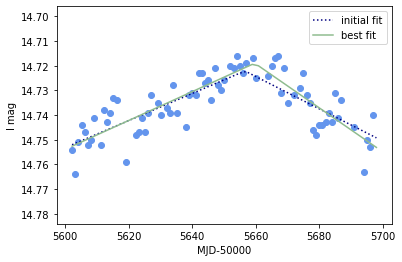

In [237]:
f.triangfit(no_outlier,flareinds,1) #also works with added data at beginning

5658.76565957861

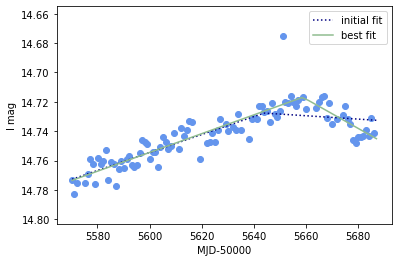

In [238]:
f.triangfit(sog4,flareinds,1,cut1=-30,cut2=5) #same as not adding start data

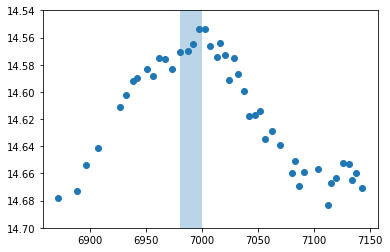

In [239]:
plt.scatter(sog4['MJD-50000'][540:585],sog4['I mag'][540:585]) #flareinds; current fits
# plt.scatter(sog4['MJD-50000'][130:160],sog4['I mag'][130:160],color='rebeccapurple') #flareinds; current fits
# plt.scatter(sog4['MJD-50000'][235:240],sog4['I mag'][235:240],color='rebeccapurple',marker='x')
plt.ylim(14.7,14.54)
plt.axvspan(6980,7000,alpha=.3) #uncertainty should go up to 7000

In [240]:
flareinds[6]

[540, 576]

In [241]:
#try without points at the end
f.oneflareg(sog4,[540,542],[576,580,585],det=True)

st: 540 end: 576 cen: 6987.96795559328
st: 540 end: 580 cen: 6987.91242900658
st: 540 end: 585 cen: 6988.152261622868
st: 542 end: 576 cen: 6987.397885671361
st: 542 end: 580 cen: 6987.330243080088
st: 542 end: 585 cen: 6987.414235073001


array([[6987.96795559, 6987.91242901, 6988.15226162],
       [6987.39788567, 6987.33024308, 6987.41423507]])

7000.45538404198

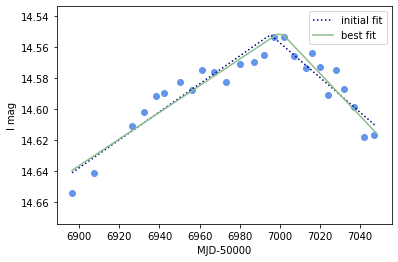

In [242]:
#try triangle otherwise probably fine
f.triangfit(sog4,flareinds,6,cut1=2,cut2=8)

In [243]:
#flerr.to_csv('flaremodels.csv')

see what happens if I use lowest value and associated stdev and highest value and associated stdev
can do further filtering for bootstrap outliers --> could help with g+line
- so trying to have actual value just be middle value between upper and lower bounds

# Try Metric to Find Centers


In [244]:
flerr['g+stdev'] = flerr['gaussian center']+flerr['gaussian stdev']
flerr['g-stdev'] = flerr['gaussian center']-flerr['gaussian stdev']
#g+line: bs stdev not included right now
# flerr['gl+stdev'] = flerr['g+line center']+flerr['g+line stdev']
# flerr['gl-stdev'] = flerr['g+line center']-flerr['g+line stdev']

#triangle
flerr['t+stdev'] = flerr['triangle center']+flerr['triangle stdev']
flerr['t-stdev'] = flerr['triangle center']-flerr['triangle stdev']

flerr['gl+stdev'] = flerr['g+line center']+flerr['g+line stdev']
flerr['gl-stdev'] = flerr['g+line center']-flerr['g+line stdev']

In [245]:
flerr

,gaussian center,med gaussian boot,gaussian stdev,g+line center,med g+line boot,g+line stdev,triangle center,med triangle boot,triangle stdev,tri-gauss,tri-g+line,g+stdev,g-stdev,t+stdev,t-stdev,gl+stdev,gl-stdev
0,5497.025629,5497.2,1.55776,5513.343428,5513.57,1.19167,5516.464173,5516.49,2.92832,19.438544,3.120745,5498.58,5495.47,5519.39,5513.54,5514.54,5512.15
1,5653.721665,5654.02,1.13032,5657.192761,5657.32,2.61838,5658.598309,5658.9,2.79163,4.876644,1.405548,5654.85,5652.59,5661.39,5655.81,5659.81,5654.57
2,5798.592549,5798.81,3.95833,5800.959890,5801.41,4.43117,5804.141488,5803.81,5.80082,5.548939,3.181598,5802.55,5794.63,5809.94,5798.34,5805.39,5796.53
3,5960.250938,5960.11,0.430399,5957.653691,5957.8,0.923187,5956.350574,5956.22,1.18446,-3.900364,-1.303117,5960.68,5959.82,5957.54,5955.17,5958.58,5956.73
4,6318.469159,6319.01,6.33337,6309.559311,6309.47,4.42053,6315.209440,6315.59,7.38252,-3.259719,5.650128,6324.8,6312.14,6322.59,6307.83,6313.98,6305.14
5,6637.294439,6637.18,2.54899,6630.221666,6629.99,1.81233,6631.191348,6630.78,5.41975,-6.103091,0.969681,6639.84,6634.75,6636.61,6625.77,6632.03,6628.41
6,6988.882603,6988.8,1.46966,6988.826699,6990.41,4.52436,6997.643335,6997.9,2.92108,8.760733,8.816636,6990.35,6987.41,7000.56,6994.72,6993.35,6984.3
7,7313.795244,7313.65,1.60283,7316.457984,7316.59,5.16328,7315.914753,7316.45,5.57513,2.119508,-0.543231,7315.4,7312.19,7321.49,7310.34,7321.62,7311.29
8,7476.981892,7477.22,3.1014,NaN,7447.3,28.8044,7483.061701,7475.88,8.58564,6.079809,NaN,7480.08,7473.88,7491.65,7474.48,NaN,NaN
9,7682.035391,7682.11,1.53815,7685.004597,7685.53,4.23855,7680.745054,7680.91,3.66955,-1.290337,-4.259544,7683.57,7680.5,7684.41,7677.08,7689.24,7680.77


In [246]:
#add minimum and maximum for each 
flerr['min'] = np.zeros(13)
flerr['max'] = np.zeros(13)

for i in range(13):
    #g+line only outside of bounds for one flare
    flerr['min'][i] = np.nanmin([flerr['g-stdev'][i],flerr['t-stdev'][i],flerr['g+line center'][i]])
    flerr['max'][i] = np.nanmax([flerr['g+stdev'][i],flerr['t+stdev'][i],flerr['g+line center'][i]])

In [247]:
#version including g+l bootstrapping
flerr['mingl'] = np.zeros(13)
flerr['maxgl'] = np.zeros(13)

for i in range(13):
    #uses all three bootstrap results
    flerr['mingl'][i] = np.nanmin([flerr['g-stdev'][i],flerr['t-stdev'][i],flerr['gl-stdev'][i]])
    flerr['maxgl'][i] = np.nanmax([flerr['g+stdev'][i],flerr['t+stdev'][i],flerr['gl+stdev'][i]])

In [248]:
#error is half the difference between the max and min values
flerr['err'] = (flerr['max']-flerr['min'])/2
flerr['errgl'] = (flerr['maxgl']-flerr['mingl'])/2


In [249]:
#middle point between max and 
flerr['mid'] = flerr['err']+flerr['min']
flerr['midgl'] = flerr['errgl']+flerr['mingl']

In [250]:
flerr #including gl bootstrap just increases error for some

,gaussian center,med gaussian boot,gaussian stdev,g+line center,med g+line boot,g+line stdev,triangle center,med triangle boot,triangle stdev,tri-gauss,...,gl+stdev,gl-stdev,min,max,mingl,maxgl,err,errgl,mid,midgl
0,5497.025629,5497.2,1.55776,5513.343428,5513.57,1.19167,5516.464173,5516.49,2.92832,19.438544,...,5514.54,5512.15,5495.467867,5519.392492,5495.467867,5519.392492,11.962313,11.962313,5507.430180,5507.430180
1,5653.721665,5654.02,1.13032,5657.192761,5657.32,2.61838,5658.598309,5658.9,2.79163,4.876644,...,5659.81,5654.57,5652.591343,5661.389936,5652.591343,5661.389936,4.399296,4.399296,5656.990640,5656.990640
2,5798.592549,5798.81,3.95833,5800.959890,5801.41,4.43117,5804.141488,5803.81,5.80082,5.548939,...,5805.39,5796.53,5794.634218,5809.942310,5794.634218,5809.942310,7.654046,7.654046,5802.288264,5802.288264
3,5960.250938,5960.11,0.430399,5957.653691,5957.8,0.923187,5956.350574,5956.22,1.18446,-3.900364,...,5958.58,5956.73,5955.166117,5960.681337,5955.166117,5960.681337,2.757610,2.757610,5957.923727,5957.923727
4,6318.469159,6319.01,6.33337,6309.559311,6309.47,4.42053,6315.209440,6315.59,7.38252,-3.259719,...,6313.98,6305.14,6307.826919,6324.802533,6305.138780,6324.802533,8.487807,9.831876,6316.314726,6314.970657
5,6637.294439,6637.18,2.54899,6630.221666,6629.99,1.81233,6631.191348,6630.78,5.41975,-6.103091,...,6632.03,6628.41,6625.771599,6639.843433,6625.771599,6639.843433,7.035917,7.035917,6632.807516,6632.807516
6,6988.882603,6988.8,1.46966,6988.826699,6990.41,4.52436,6997.643335,6997.9,2.92108,8.760733,...,6993.35,6984.3,6987.412947,7000.564414,6984.302336,7000.564414,6.575733,8.131039,6993.988681,6992.433375
7,7313.795244,7313.65,1.60283,7316.457984,7316.59,5.16328,7315.914753,7316.45,5.57513,2.119508,...,7321.62,7311.29,7310.339620,7321.489885,7310.339620,7321.621259,5.575132,5.640819,7315.914753,7315.980440
8,7476.981892,7477.22,3.1014,NaN,7447.3,28.8044,7483.061701,7475.88,8.58564,6.079809,...,NaN,NaN,7473.880495,7491.647344,7473.880495,7491.647344,8.883425,8.883425,7482.763919,7482.763919
9,7682.035391,7682.11,1.53815,7685.004597,7685.53,4.23855,7680.745054,7680.91,3.66955,-1.290337,...,7689.24,7680.77,7677.075505,7685.004597,7677.075505,7689.243150,3.964546,6.083822,7681.040051,7683.159327


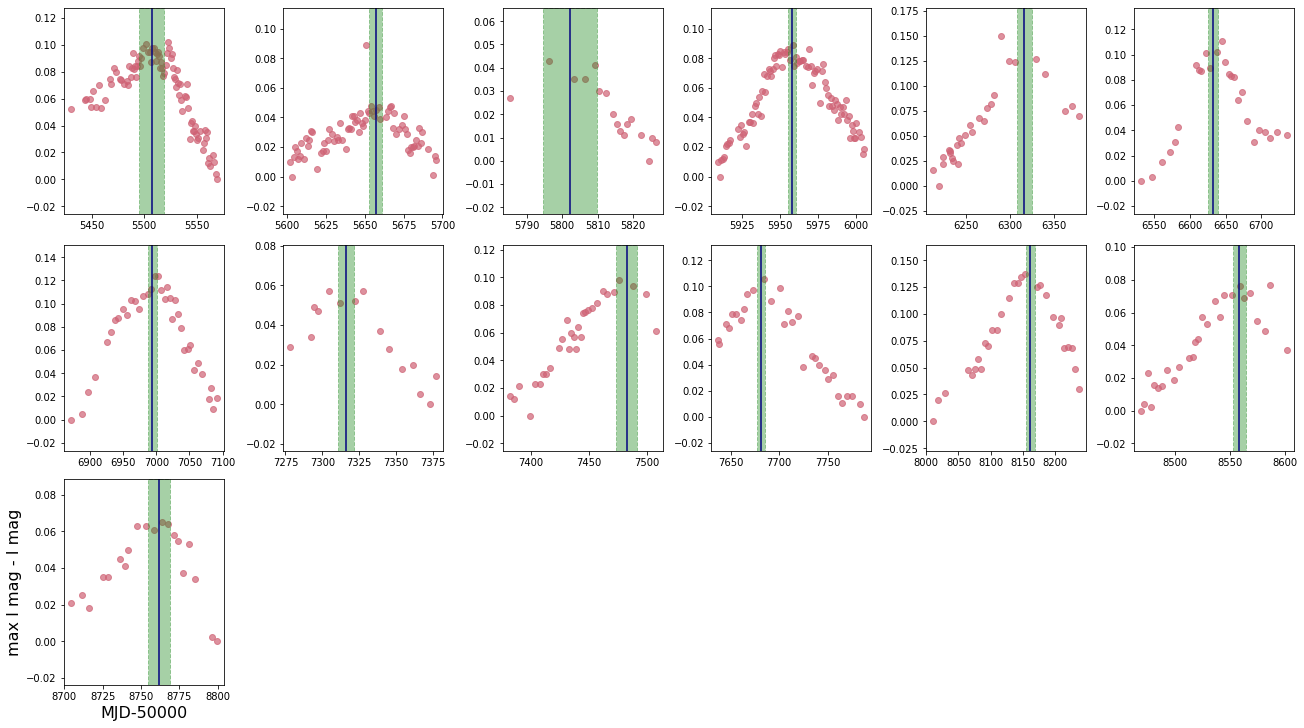

In [251]:
#plot flares with above values and errors
#only one flare has g+line outside of these bounds
fig = plt.figure(constrained_layout=True,figsize=(18,10))
gs = fig.add_gridspec(3,6)
mod2 = Model(f.gaussian) + Model(f.line)
for i in range(13):
    if i < 6: axt = fig.add_subplot(gs[0, i])
    elif i < 12: axt = fig.add_subplot(gs[1, i-6])
    else: axt = fig.add_subplot(gs[2, i-12])
    st = flareinds[i][0]
    end = flareinds[i][1]
    stdate = int(sog4['MJD-50000'][st:st+1])
    enddate = int(sog4['MJD-50000'][end-1:end])
    axt.scatter(sog4['MJD-50000'][st:end],np.max(sog4['I mag'][st:end])-sog4['I mag'][st:end],color='#CF6275',alpha=.7)
    #add shading for from min to max
    axt.axvspan(flerr['min'][i],flerr['max'][i],color='forestgreen',alpha=.4,linestyle='dashed')
    axt.axvline(flerr['mid'][i],color='navy')
plt.xlabel('MJD-50000',fontsize=16)
plt.ylabel('max I mag - I mag',fontsize=16)
png('maxmin13flares')

In [252]:
(flerr['mid']-flerr['min'])-(flerr['max']-flerr['mid'])

0     0.000000e+00
1    -9.094947e-13
2     0.000000e+00
3     9.094947e-13
4    -9.094947e-13
5     0.000000e+00
6     9.094947e-13
7     0.000000e+00
8     0.000000e+00
9     0.000000e+00
10   -9.094947e-13
11    0.000000e+00
12    0.000000e+00
dtype: float64

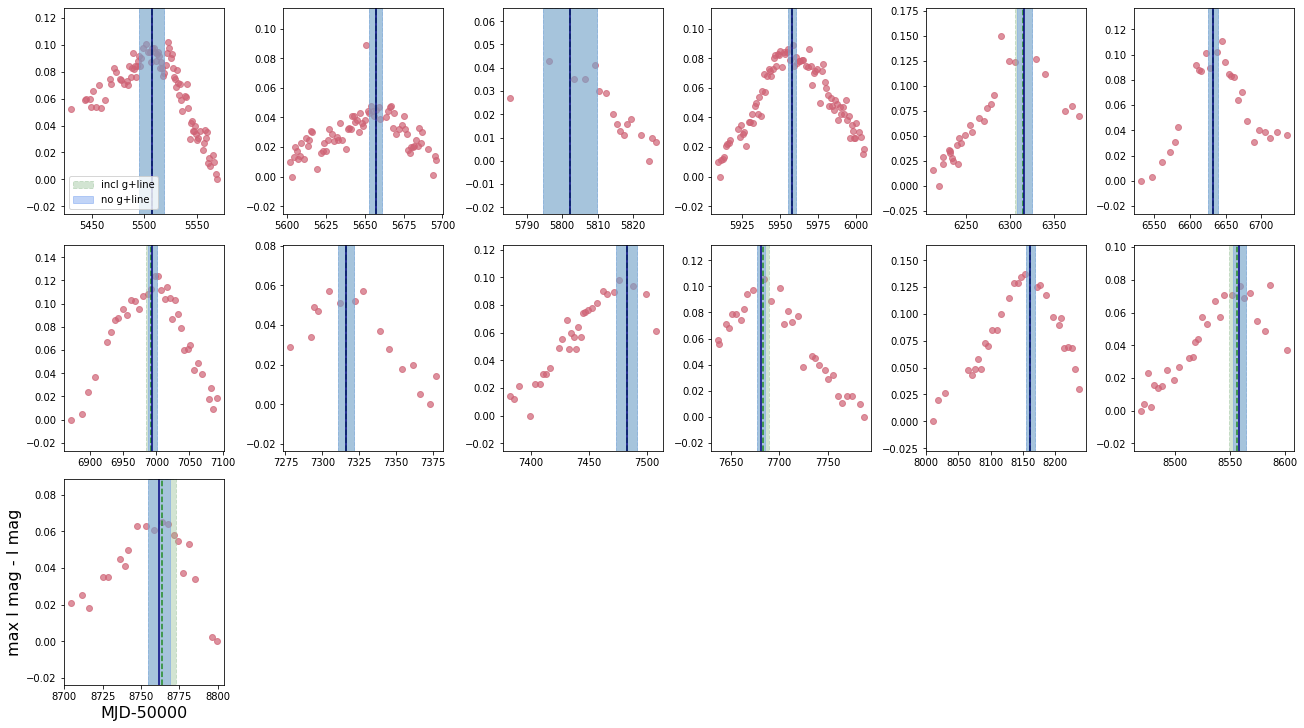

In [253]:
#version that includes g+line bootstrapping
#plot flares with above values and errors
#only one flare has g+line outside of these bounds
#notice color switch
fig = plt.figure(constrained_layout=True,figsize=(18,10))
gs = fig.add_gridspec(3,6)
mod2 = Model(f.gaussian) + Model(f.line)
for i in range(13):
    if i < 6: axt = fig.add_subplot(gs[0, i])
    elif i < 12: axt = fig.add_subplot(gs[1, i-6])
    else: axt = fig.add_subplot(gs[2, i-12])
    st = flareinds[i][0]
    end = flareinds[i][1]
    stdate = int(sog4['MJD-50000'][st:st+1])
    enddate = int(sog4['MJD-50000'][end-1:end])
    axt.scatter(sog4['MJD-50000'][st:end],np.max(sog4['I mag'][st:end])-sog4['I mag'][st:end],color='#CF6275',alpha=.7)
    #add shading for from min to max
    axt.axvspan(flerr['mingl'][i],flerr['maxgl'][i],color='darkseagreen',alpha=.4,linestyle='dashed',label='incl g+line')
    axt.axvline(flerr['midgl'][i],color='forestgreen',linestyle='dashed')
    axt.axvspan(flerr['min'][i],flerr['max'][i],color='cornflowerblue',alpha=.4,label='no g+line')
    axt.axvline(flerr['mid'][i],color='navy')
    if i == 0: plt.legend()
plt.xlabel('MJD-50000',fontsize=16)
plt.ylabel('max I mag - I mag',fontsize=16)
png('maxmin13flaresgl')

In [254]:
flerr.to_csv('flaremodels.csv')

next steps
- check if other tests returned reasonable centers outside of these ranges
    - very few tests outside of ranges, but only by ~a day
- can take outliers out of bootstrapping
    - going back and taking outliers out of g+line; may repeat for others
- if enough points and asymmetrical, try out with flat continuum

In [255]:
for i in range(len(all_gcens)):
    for j in range(13):
        if all_gcens[i][j] < flerr['min'][j] or all_gcens[i][j] > flerr['max'][j]:
            print(i,j,all_gcens[i][j])
#all within a day of min or max

2 1 5652.408798601163
2 10 8153.528639089399
2 12 8754.079482601514
3 1 5652.228500268087
3 5 6640.038283794892
3 10 8152.868497046725
3 12 8753.72788465776
4 1 5652.119264233643
4 5 6640.305514223728
4 10 8152.351691571171
4 12 8753.504668746775
7 9 7685.519543437794


In [256]:
15/(8*13) #fraction of gaussian fits outside of error range (so detrended, offset 0.06, det g+line)

0.14423076923076922

In [257]:
#can read in if not all executed 
#flerr = pd.read_csv('flaremodels.csv')

In [258]:
#try fits to symmetrical flares
flerr

,gaussian center,med gaussian boot,gaussian stdev,g+line center,med g+line boot,g+line stdev,triangle center,med triangle boot,triangle stdev,tri-gauss,...,gl+stdev,gl-stdev,min,max,mingl,maxgl,err,errgl,mid,midgl
0,5497.025629,5497.2,1.55776,5513.343428,5513.57,1.19167,5516.464173,5516.49,2.92832,19.438544,...,5514.54,5512.15,5495.467867,5519.392492,5495.467867,5519.392492,11.962313,11.962313,5507.430180,5507.430180
1,5653.721665,5654.02,1.13032,5657.192761,5657.32,2.61838,5658.598309,5658.9,2.79163,4.876644,...,5659.81,5654.57,5652.591343,5661.389936,5652.591343,5661.389936,4.399296,4.399296,5656.990640,5656.990640
2,5798.592549,5798.81,3.95833,5800.959890,5801.41,4.43117,5804.141488,5803.81,5.80082,5.548939,...,5805.39,5796.53,5794.634218,5809.942310,5794.634218,5809.942310,7.654046,7.654046,5802.288264,5802.288264
3,5960.250938,5960.11,0.430399,5957.653691,5957.8,0.923187,5956.350574,5956.22,1.18446,-3.900364,...,5958.58,5956.73,5955.166117,5960.681337,5955.166117,5960.681337,2.757610,2.757610,5957.923727,5957.923727
4,6318.469159,6319.01,6.33337,6309.559311,6309.47,4.42053,6315.209440,6315.59,7.38252,-3.259719,...,6313.98,6305.14,6307.826919,6324.802533,6305.138780,6324.802533,8.487807,9.831876,6316.314726,6314.970657
5,6637.294439,6637.18,2.54899,6630.221666,6629.99,1.81233,6631.191348,6630.78,5.41975,-6.103091,...,6632.03,6628.41,6625.771599,6639.843433,6625.771599,6639.843433,7.035917,7.035917,6632.807516,6632.807516
6,6988.882603,6988.8,1.46966,6988.826699,6990.41,4.52436,6997.643335,6997.9,2.92108,8.760733,...,6993.35,6984.3,6987.412947,7000.564414,6984.302336,7000.564414,6.575733,8.131039,6993.988681,6992.433375
7,7313.795244,7313.65,1.60283,7316.457984,7316.59,5.16328,7315.914753,7316.45,5.57513,2.119508,...,7321.62,7311.29,7310.339620,7321.489885,7310.339620,7321.621259,5.575132,5.640819,7315.914753,7315.980440
8,7476.981892,7477.22,3.1014,NaN,7447.3,28.8044,7483.061701,7475.88,8.58564,6.079809,...,NaN,NaN,7473.880495,7491.647344,7473.880495,7491.647344,8.883425,8.883425,7482.763919,7482.763919
9,7682.035391,7682.11,1.53815,7685.004597,7685.53,4.23855,7680.745054,7680.91,3.66955,-1.290337,...,7689.24,7680.77,7677.075505,7685.004597,7677.075505,7689.243150,3.964546,6.083822,7681.040051,7683.159327


In [260]:
#try out symmetrical cut
st = sog4['I mag'][40]
end = sog4['I mag'][129]
#find which one is brighter
if st<end: #if I mag lower, so if start is brighter, so it defines cutoff
    endcut = True
    i = 1
    while endcut:
        if sog4['I mag'][129-i] <= st:
            endcut = False
            #save ind to cut at
            indcut = 129-i+1 
        i+=1
else:
    endcut = True
    i = 1
    while endcut:
        if sog4['I mag'][40+i] <= end:
            endcut = False
            #save ind to cut at
            indcut = 40+i-1
        i+=1
indcut #new end or start to use

108

In [261]:
#now try fit on first flare from 40 to 108
f.oneflareg(sog4,[40],[108])

st: 40 end: 108 cen: 5504.393070794919


array([[5504.39307079]])

In [262]:
f.oneflareg(sog4,[40],[108],det=True)

st: 40 end: 108 cen: 5507.03181968829


array([[5507.03181969]])

In [263]:
#try for other flares
def symfind(sog4,flareinds,ind):
    si = flareinds[ind][0]
    ei = flareinds[ind][1]
    st = sog4['I mag'][si]
    end = sog4['I mag'][ei]
    #find which one is brighter
    if st<end: #if I mag lower, so if start is brighter, so it defines cutoff
        endcut = True
        i = 1
        while endcut:
            if sog4['I mag'][ei-i] <= st:
                endcut = False
                #save ind to cut at
                indcut = ei-i+1 
            i+=1
    else:
        endcut = True
        i = 1
        while endcut:
            if sog4['I mag'][si+i] <= end:
                endcut = False
                #save ind to cut at
                indcut = si+i-1
            i+=1
    if st<end: return si,indcut #new inds to use
    else: return indcut,ei

In [264]:
def symfit(sog4,flareinds,ind,gline=False,det=False):
    si = flareinds[ind][0]
    ei = flareinds[ind][1]
    if ei-si > 30:
        print('trying symmetrical')
        st,end = symfind(sog4,flareinds,ind)
        print(st,end)
        newcen = f.oneflareg(sog4,[st],[end],det=det,gline=gline)
        return newcen
    else:
        print('not enough points')
        return

In [265]:
for i in range(13):
    symfit(sog4,flareinds,i)

trying symmetrical
40 108
st: 40 end: 108 cen: 5504.393070794919
trying symmetrical
168 235
st: 168 end: 235 cen: 5654.408679900398
not enough points
trying symmetrical
338 420
st: 338 end: 420 cen: 5959.852290173513
not enough points
not enough points
trying symmetrical
541 576
st: 541 end: 576 cen: 6988.7442801492625
not enough points
not enough points
not enough points
not enough points
not enough points
not enough points


In [266]:
flerr['gaussian center'] #only first flare really changes

0     5497.025629
1     5653.721665
2     5798.592549
3     5960.250938
4     6318.469159
5     6637.294439
6     6988.882603
7     7313.795244
8     7476.981892
9     7682.035391
10    8155.107214
11    8559.433758
12    8755.943745
Name: gaussian center, dtype: float64

## check difference with triangle fit 3D grids

In [268]:
trigrids = [f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13]

In [279]:
i=0
leng=0
for t in trigrids:
    leng+=len(t)
    if np.min(t)<flerr['min'][i]:
        print(i,np.min(t),flerr['min'][i]-np.min(t))
    if np.max(t)>flerr['max'][i]:
        print(i,np.max(t),np.max(t)-flerr['max'][i])
    i+=1
print('len:',leng)

0 5519.71681403845 0.3243219135065374
4 6299.283737332051 8.543181852631278
6 7002.128683836984 1.5642697975108604
7 7307.380983164823 2.958637040924259
7 7327.556466653068 6.066581571555616
8 7470.7551313465065 3.1253633122569227
len: 54


In [273]:
i=0
for t in trigrids:
    if np.min(t)<flerr['mingl'][i]:
        print(np.min(t),flerr['mingl'][i]-np.min(t))
    if np.max(t)>flerr['maxgl'][i]:
        print(np.max(t),np.max(t)-flerr['maxgl'][i])
    i+=1

5519.71681403845 0.3243219135065374
6299.283737332051 5.85504315628441
7002.128683836984 1.5642697975108604
7307.380983164823 2.958637040924259
7327.556466653068 5.935207690222342
7470.7551313465065 3.1253633122569227


In [274]:
len(trigrids)

13

In [278]:
6/54

0.1111111111111111

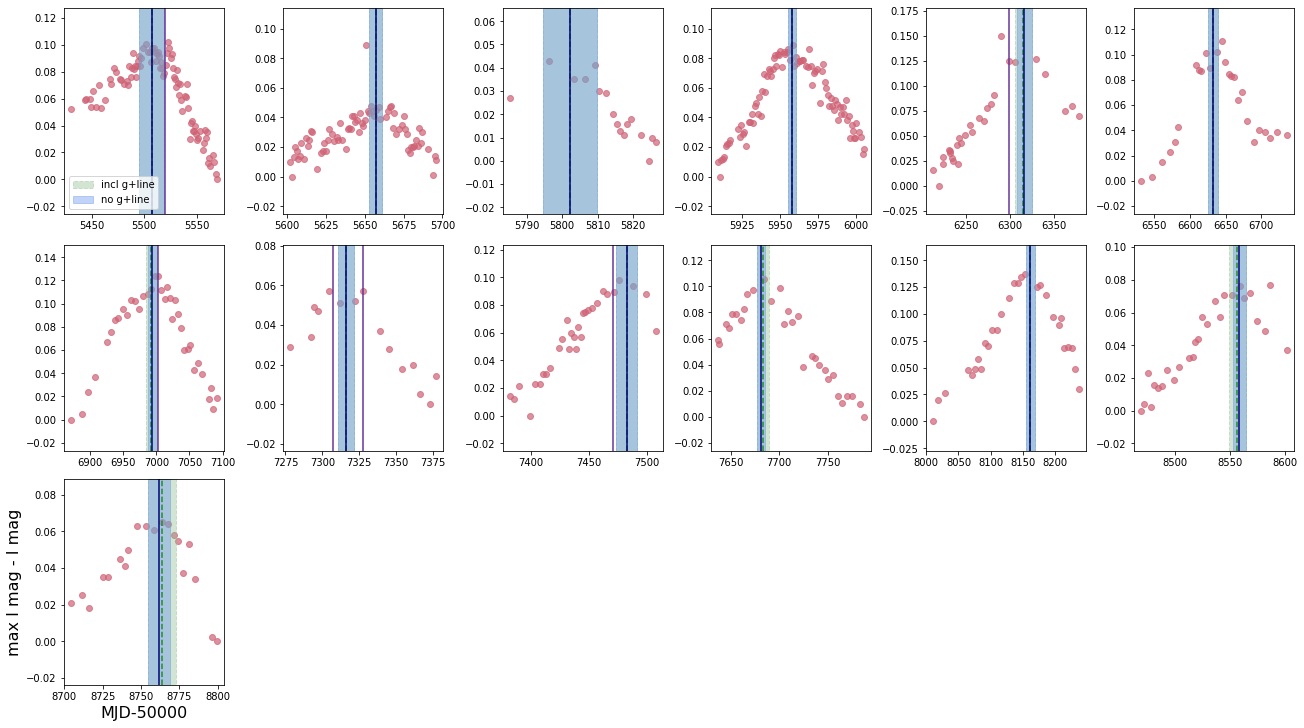

In [281]:
#repeating plot for now with centers from triangle 3D grids
fig = plt.figure(constrained_layout=True,figsize=(18,10))
gs = fig.add_gridspec(3,6)
mod2 = Model(f.gaussian) + Model(f.line)
for i in range(13):
    if i < 6: axt = fig.add_subplot(gs[0, i])
    elif i < 12: axt = fig.add_subplot(gs[1, i-6])
    else: axt = fig.add_subplot(gs[2, i-12])
    st = flareinds[i][0]
    end = flareinds[i][1]
    stdate = int(sog4['MJD-50000'][st:st+1])
    enddate = int(sog4['MJD-50000'][end-1:end])
    axt.scatter(sog4['MJD-50000'][st:end],np.max(sog4['I mag'][st:end])-sog4['I mag'][st:end],color='#CF6275',alpha=.7)
    #add shading for from min to max
    axt.axvspan(flerr['mingl'][i],flerr['maxgl'][i],color='darkseagreen',alpha=.4,linestyle='dashed',label='incl g+line')
    axt.axvline(flerr['midgl'][i],color='forestgreen',linestyle='dashed')
    axt.axvspan(flerr['min'][i],flerr['max'][i],color='cornflowerblue',alpha=.4,label='no g+line')
    axt.axvline(flerr['mid'][i],color='navy')
    
    if i == 0:
        plt.axvline(5519.7,color='rebeccapurple')
    elif i == 4:
        plt.axvline(6299.2,color='rebeccapurple')
    elif i == 6:
        plt.axvline(7002.1,color='rebeccapurple')
    elif i == 7:
        plt.axvline(7307.4,color='rebeccapurple')
        plt.axvline(7327.6,color='rebeccapurple')
    elif i == 8:
        plt.axvline(7470.8,color='rebeccapurple')

    if i == 0: plt.legend()
plt.xlabel('MJD-50000',fontsize=16)
plt.ylabel('max I mag - I mag',fontsize=16)
png('triout')

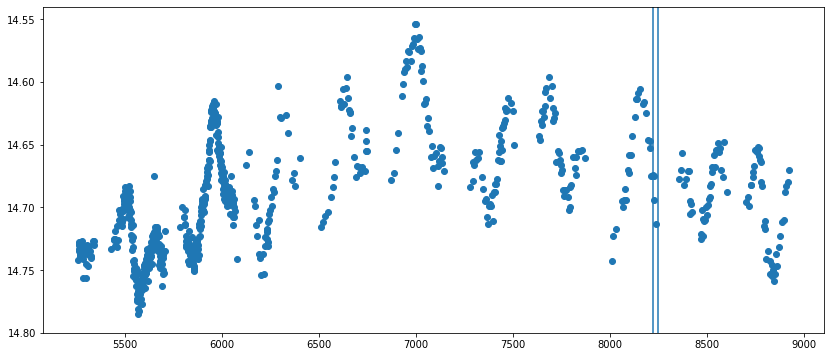

In [285]:
plt.figure(figsize=(14,6))
plt.scatter(sog4['MJD-50000'],sog4['I mag'])
plt.ylim(14.8,14.54)
plt.axvline(8220)
plt.axvline(8250)


In [286]:
flareinds

[[40, 130],
 [160, 235],
 [241, 258],
 [330, 420],
 [478, 507],
 [510, 536],
 [540, 576],
 [585, 600],
 [600, 630],
 [630, 660],
 [671, 700],
 [711, 738],
 [738, 758]]